## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.

For future models, a suggestion is to embed the training/testing functions in a Model class, instead of keeping them loose from each other. (With, optimally, inheritance from a base class, etc etc, such that there is minimal code duplication.) This way, the training procedure can be easily tailored per model. In the current set-up, different functions have to be called for fully-connected networks and hierarchical networks because they handle the data differently. Another way this would be a worth investment, is for implementation of physics-informed models, which require a whole physics injection into the training procedure. In that case, tight coupling is much recommended over the current state of this file. Therefore, I'd first change the code such that it works per model and such that only functionalities independent of model type are actually independent/loosely coupled from the models, therewith facilitating scalable experimentation.

Throughout the notebook, there are printing statements to clarify potential errors happening on Habrok

## TO DO
- define wd, wind speed and no2 indexes after datasets are defined
- make MLP class to parse in a loss function defined in global variable
- have the loss function by default is mse 
- then make the phy loss func

In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress

BASE_DIR = Path.cwd().parents[0] # set it to the root directory of the project, not src
MODEL_PATH = BASE_DIR /"src" / "results" / "models"
MINMAX_PATH = BASE_DIR  / "data" / "data_combined" / "pollutants_minmax.csv"

print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("MINMAX_PATH: ", MINMAX_PATH)

torch.manual_seed(34)             # set seed for reproducibility

N_HOURS_U = 24 * 3               # number of hours to use for input (number of days * 24 hours)
N_HOURS_Y = 24                    # number of hours to predict (1 day * 24 hours)
N_HOURS_STEP = 24                 # "sampling rate" in hours of the data; e.g. 24 
                                  # means sample an I/O-pair every 24 hours
                                  # the contaminants and meteorological vars

# Change this according to the data you want to use
YEARS = [2017]
TRAIN_YEARS = [2017]
VAL_YEARS = [2017]
TEST_YEARS = [2017]

LOSS_FUNC = "Physics_MSE" # choose from "MSE" and "Physics_MSE"

BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/pollutants_minmax.csv


### **Load in data and create PyTorch *Datasets***

In [5]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS)
train_output_frames = get_dataframes('train', 'y', YEARS)

val_input_frames = get_dataframes('val', 'u', YEARS)
val_output_frames = get_dataframes('val', 'y', YEARS)

test_input_frames = get_dataframes('test', 'u', YEARS)
test_output_frames = get_dataframes('test', 'y', YEARS) 

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2017_combined_y.csv
Imported val_2017_combined_u.csv
Imported val_2017_combined_y.csv
Imported test_2017_combined_u.csv
Imported test_2017_combined_y.csv
Successfully loaded data


In [6]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [7]:
train_dataset.u

[                           DD   FF        FH        FX       NO2         P  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.1  0.111111  0.000000  0.242115  0.562982   
 2017-08-01 01:00:00  0.000000  0.0  0.111111  0.052632  0.223158  0.570694   
 2017-08-01 02:00:00  0.000000  0.0  0.000000  0.000000  0.165911  0.560411   
 2017-08-01 03:00:00  0.277778  0.1  0.000000  0.000000  0.142363  0.555270   
 2017-08-01 04:00:00  0.805556  0.2  0.111111  0.105263  0.156297  0.555270   
 ...                       ...  ...       ...       ...       ...       ...   
 2017-11-16 19:00:00  0.750000  0.2  0.333333  0.210526  0.523871  0.789203   
 2017-11-16 20:00:00  0.972222  0.3  0.333333  0.421053  0.512314  0.814910   
 2017-11-16 21:00:00  0.888889  0.1  0.222222  0.263158  0.232880  0.827763   
 2017-11-16 22:00:00  0.944444  0.2  0.111111  0.105263  0.108123  0.832905   
 2017-11-16 23:00:00  0.861111  0.1  0.222222  0.105

In [8]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.223698
 2017-08-01 01:00:00  0.145496
 2017-08-01 02:00:00  0.275978
 2017-08-01 03:00:00  0.423742
 2017-08-01 04:00:00  0.478721
 ...                       ...
 2017-11-16 19:00:00  0.606502
 2017-11-16 20:00:00  0.456470
 2017-11-16 21:00:00  0.483258
 2017-11-16 22:00:00  0.468784
 2017-11-16 23:00:00  0.473428
 
 [2592 rows x 1 columns]]

In [9]:
len(train_dataset.pairs[0][0])

72

In [10]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.1000, 0.1111, 0.0000, 0.2421, 0.5630, 0.0000, 0.5367, 0.7269],
        [0.0000, 0.0000, 0.1111, 0.0526, 0.2232, 0.5707, 0.0000, 0.5467, 0.7407],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1659, 0.5604, 0.0000, 0.5067, 0.6898],
        [0.2778, 0.1000, 0.0000, 0.0000, 0.1424, 0.5553, 0.0000, 0.4633, 0.6343],
        [0.8056, 0.2000, 0.1111, 0.1053, 0.1563, 0.5553, 0.0000, 0.4933, 0.6620],
        [0.0000, 0.0000, 0.1111, 0.1053, 0.3135, 0.5681, 0.3000, 0.6200, 0.7593],
        [0.7222, 0.1000, 0.1111, 0.0526, 0.5326, 0.5913, 0.0000, 0.6433, 0.7269],
        [0.7500, 0.1000, 0.1111, 0.1053, 0.5367, 0.5938, 0.0000, 0.6500, 0.7037],
        [0.7222, 0.2000, 0.2222, 0.1053, 0.5172, 0.5964, 0.0000, 0.6733, 0.6574],
        [0.7500, 0.2000, 0.2222, 0.2105, 0.4459, 0.5990, 0.3000, 0.7133, 0.6157],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3129, 0.6041, 0.0000, 0.7167, 0.6019],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3478, 0.6067, 0.0000, 0.7133, 0.5926],
        [0.6528,

In [11]:
train_dataset.pairs[0][1]

tensor([[0.1965],
        [0.1501],
        [0.1518],
        [0.2622],
        [0.5524],
        [0.4840],
        [0.3544],
        [0.2754],
        [0.1948],
        [0.1734],
        [0.1505],
        [0.1352],
        [0.0778],
        [0.1184],
        [0.1293],
        [0.1238],
        [0.1043],
        [0.0997],
        [0.0812],
        [0.0823],
        [0.1155],
        [0.0837],
        [0.0570],
        [0.1006]])

In [12]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list

# Now, find the indices of the columns 'NO2', 'DD', 'FH'
no2_idx = column_names.index('NO2')
dd_idx = column_names.index('DD')
fh_idx = column_names.index('FH')

print("NO2 index: ", no2_idx)
print("DD index (wind direction): ", dd_idx)
print("FH index (Hourly wind speed): ", fh_idx)


NO2 index:  4
DD index (wind direction):  0
FH index (Hourly wind speed):  2


In [13]:
train_dataset.u[0].iloc[:,no2_idx]

DateTime
2017-08-01 00:00:00    0.242115
2017-08-01 01:00:00    0.223158
2017-08-01 02:00:00    0.165911
2017-08-01 03:00:00    0.142363
2017-08-01 04:00:00    0.156297
                         ...   
2017-11-16 19:00:00    0.523871
2017-11-16 20:00:00    0.512314
2017-11-16 21:00:00    0.232880
2017-11-16 22:00:00    0.108123
2017-11-16 23:00:00    0.205120
Name: NO2, Length: 2592, dtype: float64

In [14]:
train_dataset.u[0].iloc[:,dd_idx]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-11-16 19:00:00    0.750000
2017-11-16 20:00:00    0.972222
2017-11-16 21:00:00    0.888889
2017-11-16 22:00:00    0.944444
2017-11-16 23:00:00    0.861111
Name: DD, Length: 2592, dtype: float64

In [15]:
train_dataset.u[0].iloc[:,fh_idx]

DateTime
2017-08-01 00:00:00    0.111111
2017-08-01 01:00:00    0.111111
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.111111
                         ...   
2017-11-16 19:00:00    0.333333
2017-11-16 20:00:00    0.333333
2017-11-16 21:00:00    0.222222
2017-11-16 22:00:00    0.111111
2017-11-16 23:00:00    0.222222
Name: FH, Length: 2592, dtype: float64

### **Start hyperparameter searching with Optuna**

In [17]:
def objective(trial):
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Match the original hp['batch_sz']

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, device=device)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", study_name="mlp_hyperparameter_optimization_phy12", storage="sqlite:///mlp_hyperparameter_optimization_phy.db", load_if_exists=True)

study.optimize(objective, n_trials=100)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)




[I 2025-03-02 00:13:01,461] A new study created in RDB with name: mlp_hyperparameter_optimization_phy12
/tmp/ipykernel_10196/3654659993.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_10196/3654659993.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)


Epoch 1/50 - Train Loss: 0.124608 - Val Loss: 0.220441
Epoch 2/50 - Train Loss: 0.103983 - Val Loss: 0.193476
Epoch 3/50 - Train Loss: 0.082671 - Val Loss: 0.170309
Epoch 4/50 - Train Loss: 0.074284 - Val Loss: 0.150742
Epoch 5/50 - Train Loss: 0.064969 - Val Loss: 0.134066
Epoch 6/50 - Train Loss: 0.056640 - Val Loss: 0.120293
Epoch 7/50 - Train Loss: 0.053409 - Val Loss: 0.108908
Epoch 8/50 - Train Loss: 0.050627 - Val Loss: 0.100186
Epoch 9/50 - Train Loss: 0.046628 - Val Loss: 0.092645
Epoch 10/50 - Train Loss: 0.040817 - Val Loss: 0.087346
Epoch 11/50 - Train Loss: 0.041083 - Val Loss: 0.083334
Epoch 12/50 - Train Loss: 0.042433 - Val Loss: 0.080606
Epoch 13/50 - Train Loss: 0.040406 - Val Loss: 0.077999
Epoch 14/50 - Train Loss: 0.037505 - Val Loss: 0.076397
Epoch 15/50 - Train Loss: 0.042029 - Val Loss: 0.075398
Epoch 16/50 - Train Loss: 0.041021 - Val Loss: 0.074423
Epoch 17/50 - Train Loss: 0.042700 - Val Loss: 0.073493
Epoch 18/50 - Train Loss: 0.039964 - Val Loss: 0.072723
E

[I 2025-03-02 00:13:16,975] Trial 0 finished with value: 0.057217858731746674 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 195, 'lr': 3.0462883081823548e-05, 'weight_decay': 1.1371901009505448e-06, 'batch_size': 16}. Best is trial 0 with value: 0.057217858731746674.


Epoch 50/50 - Train Loss: 0.031409 - Val Loss: 0.057218
Epoch 1/50 - Train Loss: 0.205347 - Val Loss: 0.310594
Epoch 2/50 - Train Loss: 0.152031 - Val Loss: 0.201963
Epoch 3/50 - Train Loss: 0.069586 - Val Loss: 0.099181
Epoch 4/50 - Train Loss: 0.053875 - Val Loss: 0.073723
Epoch 5/50 - Train Loss: 0.075701 - Val Loss: 0.077920
Epoch 6/50 - Train Loss: 0.045937 - Val Loss: 0.103797
Epoch 7/50 - Train Loss: 0.044478 - Val Loss: 0.123705
Epoch 8/50 - Train Loss: 0.057484 - Val Loss: 0.123431
Epoch 9/50 - Train Loss: 0.056736 - Val Loss: 0.106982
Epoch 10/50 - Train Loss: 0.050186 - Val Loss: 0.084066
Epoch 11/50 - Train Loss: 0.038696 - Val Loss: 0.067850
Epoch 12/50 - Train Loss: 0.040645 - Val Loss: 0.062933
Epoch 13/50 - Train Loss: 0.040499 - Val Loss: 0.064320
Epoch 14/50 - Train Loss: 0.044903 - Val Loss: 0.072469
Epoch 15/50 - Train Loss: 0.035661 - Val Loss: 0.079524
Epoch 16/50 - Train Loss: 0.037127 - Val Loss: 0.078963
Epoch 17/50 - Train Loss: 0.044112 - Val Loss: 0.069203
E

[I 2025-03-02 00:13:34,697] Trial 1 finished with value: 0.04389261454343796 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 249, 'lr': 0.0007185007887608011, 'weight_decay': 1.3246580882625853e-06, 'batch_size': 64}. Best is trial 1 with value: 0.04389261454343796.


Epoch 50/50 - Train Loss: 0.034782 - Val Loss: 0.045859
Epoch 1/50 - Train Loss: 0.121124 - Val Loss: 0.164159
Epoch 2/50 - Train Loss: 0.069913 - Val Loss: 0.107111
Epoch 3/50 - Train Loss: 0.049967 - Val Loss: 0.066332
Epoch 4/50 - Train Loss: 0.041209 - Val Loss: 0.090117
Epoch 5/50 - Train Loss: 0.041159 - Val Loss: 0.059292
Epoch 6/50 - Train Loss: 0.041062 - Val Loss: 0.059259
Epoch 7/50 - Train Loss: 0.034304 - Val Loss: 0.058684
Epoch 8/50 - Train Loss: 0.033034 - Val Loss: 0.046601
Epoch 9/50 - Train Loss: 0.033486 - Val Loss: 0.054049
Epoch 10/50 - Train Loss: 0.034306 - Val Loss: 0.044286
Epoch 11/50 - Train Loss: 0.030784 - Val Loss: 0.054680
Epoch 12/50 - Train Loss: 0.032192 - Val Loss: 0.043858
Epoch 13/50 - Train Loss: 0.034559 - Val Loss: 0.051083
Epoch 14/50 - Train Loss: 0.035294 - Val Loss: 0.044842
Epoch 15/50 - Train Loss: 0.032686 - Val Loss: 0.044431
Epoch 16/50 - Train Loss: 0.033239 - Val Loss: 0.047208
Epoch 17/50 - Train Loss: 0.032792 - Val Loss: 0.044106
E

[I 2025-03-02 00:13:55,257] Trial 2 finished with value: 0.043729208409786224 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 202, 'lr': 0.004085478849534725, 'weight_decay': 6.799311720673112e-08, 'batch_size': 32}. Best is trial 2 with value: 0.043729208409786224.


Epoch 50/50 - Train Loss: 0.026247 - Val Loss: 0.059374
Epoch 1/50 - Train Loss: 0.116920 - Val Loss: 0.231880
Epoch 2/50 - Train Loss: 0.108921 - Val Loss: 0.225285
Epoch 3/50 - Train Loss: 0.107158 - Val Loss: 0.218885
Epoch 4/50 - Train Loss: 0.101906 - Val Loss: 0.212680
Epoch 5/50 - Train Loss: 0.098821 - Val Loss: 0.206629
Epoch 6/50 - Train Loss: 0.094171 - Val Loss: 0.200914
Epoch 7/50 - Train Loss: 0.092588 - Val Loss: 0.195266
Epoch 8/50 - Train Loss: 0.086343 - Val Loss: 0.189772
Epoch 9/50 - Train Loss: 0.085898 - Val Loss: 0.184578
Epoch 10/50 - Train Loss: 0.083681 - Val Loss: 0.179352
Epoch 11/50 - Train Loss: 0.079347 - Val Loss: 0.174198
Epoch 12/50 - Train Loss: 0.078006 - Val Loss: 0.169055
Epoch 13/50 - Train Loss: 0.073409 - Val Loss: 0.164141
Epoch 14/50 - Train Loss: 0.068165 - Val Loss: 0.159640
Epoch 15/50 - Train Loss: 0.064209 - Val Loss: 0.155459
Epoch 16/50 - Train Loss: 0.069662 - Val Loss: 0.151191
Epoch 17/50 - Train Loss: 0.064188 - Val Loss: 0.147056
E

[I 2025-03-02 00:14:13,354] Trial 3 finished with value: 0.08962612599134445 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 38, 'lr': 3.4121219939997605e-05, 'weight_decay': 1.8324658768271532e-06, 'batch_size': 8}. Best is trial 2 with value: 0.043729208409786224.


Epoch 50/50 - Train Loss: 0.044157 - Val Loss: 0.089626
Epoch 1/50 - Train Loss: 0.134438 - Val Loss: 0.220906
Epoch 2/50 - Train Loss: 0.089736 - Val Loss: 0.161467
Epoch 3/50 - Train Loss: 0.062643 - Val Loss: 0.105863
Epoch 4/50 - Train Loss: 0.049896 - Val Loss: 0.072380
Epoch 5/50 - Train Loss: 0.047573 - Val Loss: 0.070468
Epoch 6/50 - Train Loss: 0.047865 - Val Loss: 0.084451
Epoch 7/50 - Train Loss: 0.040714 - Val Loss: 0.084707
Epoch 8/50 - Train Loss: 0.042536 - Val Loss: 0.078422
Epoch 9/50 - Train Loss: 0.042501 - Val Loss: 0.072953
Epoch 10/50 - Train Loss: 0.041465 - Val Loss: 0.073946
Epoch 11/50 - Train Loss: 0.042068 - Val Loss: 0.072673
Epoch 12/50 - Train Loss: 0.042020 - Val Loss: 0.063524
Epoch 13/50 - Train Loss: 0.038594 - Val Loss: 0.061148
Epoch 14/50 - Train Loss: 0.035348 - Val Loss: 0.060087
Epoch 15/50 - Train Loss: 0.037337 - Val Loss: 0.052503
Epoch 16/50 - Train Loss: 0.034093 - Val Loss: 0.051937
Epoch 17/50 - Train Loss: 0.032850 - Val Loss: 0.048491
E

[I 2025-03-02 00:14:30,959] Trial 4 finished with value: 0.04451085813343525 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 43, 'lr': 0.0008538905075914349, 'weight_decay': 1.4532946814411318e-05, 'batch_size': 16}. Best is trial 2 with value: 0.043729208409786224.


Epoch 50/50 - Train Loss: 0.033428 - Val Loss: 0.045074
Epoch 1/50 - Train Loss: 0.219298 - Val Loss: 0.414347
Epoch 2/50 - Train Loss: 0.213483 - Val Loss: 0.396902
Epoch 3/50 - Train Loss: 0.195017 - Val Loss: 0.379123
Epoch 4/50 - Train Loss: 0.178823 - Val Loss: 0.361005
Epoch 5/50 - Train Loss: 0.175361 - Val Loss: 0.342022
Epoch 6/50 - Train Loss: 0.160806 - Val Loss: 0.319720
Epoch 7/50 - Train Loss: 0.140911 - Val Loss: 0.294014
Epoch 8/50 - Train Loss: 0.129833 - Val Loss: 0.263468
Epoch 9/50 - Train Loss: 0.112972 - Val Loss: 0.227536
Epoch 10/50 - Train Loss: 0.095563 - Val Loss: 0.187856
Epoch 11/50 - Train Loss: 0.077812 - Val Loss: 0.145935
Epoch 12/50 - Train Loss: 0.053402 - Val Loss: 0.113257
Epoch 13/50 - Train Loss: 0.049718 - Val Loss: 0.091985
Epoch 14/50 - Train Loss: 0.046672 - Val Loss: 0.086627
Epoch 15/50 - Train Loss: 0.044761 - Val Loss: 0.086897
Epoch 16/50 - Train Loss: 0.045567 - Val Loss: 0.088345
Epoch 17/50 - Train Loss: 0.045435 - Val Loss: 0.089523
E

[I 2025-03-02 00:15:06,702] Trial 5 finished with value: 0.050455822298924126 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 94, 'lr': 6.026132016313157e-05, 'weight_decay': 3.22086948041954e-07, 'batch_size': 8}. Best is trial 2 with value: 0.043729208409786224.


Epoch 50/50 - Train Loss: 0.034446 - Val Loss: 0.051817
Epoch 1/50 - Train Loss: 0.113811 - Val Loss: 0.222578
Epoch 2/50 - Train Loss: 0.092107 - Val Loss: 0.201186
Epoch 3/50 - Train Loss: 0.087170 - Val Loss: 0.181578
Epoch 4/50 - Train Loss: 0.068337 - Val Loss: 0.164148
Epoch 5/50 - Train Loss: 0.066857 - Val Loss: 0.148594
Epoch 6/50 - Train Loss: 0.061005 - Val Loss: 0.134504
Epoch 7/50 - Train Loss: 0.053340 - Val Loss: 0.122629
Epoch 8/50 - Train Loss: 0.048335 - Val Loss: 0.112361
Epoch 9/50 - Train Loss: 0.043324 - Val Loss: 0.104384
Epoch 10/50 - Train Loss: 0.048150 - Val Loss: 0.098093
Epoch 11/50 - Train Loss: 0.041598 - Val Loss: 0.093018
Epoch 12/50 - Train Loss: 0.041390 - Val Loss: 0.089179
Epoch 13/50 - Train Loss: 0.043318 - Val Loss: 0.086049
Epoch 14/50 - Train Loss: 0.042477 - Val Loss: 0.083915
Epoch 15/50 - Train Loss: 0.040435 - Val Loss: 0.082658
Epoch 16/50 - Train Loss: 0.039840 - Val Loss: 0.081782
Epoch 17/50 - Train Loss: 0.041106 - Val Loss: 0.081389
E

[I 2025-03-02 00:15:18,987] Trial 6 finished with value: 0.06019306927919388 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 91, 'lr': 6.694563242510557e-05, 'weight_decay': 0.0001240594870093528, 'batch_size': 16}. Best is trial 2 with value: 0.043729208409786224.


Epoch 50/50 - Train Loss: 0.032782 - Val Loss: 0.060193
Epoch 1/50 - Train Loss: 0.081425 - Val Loss: 0.171930
Epoch 2/50 - Train Loss: 0.072114 - Val Loss: 0.151543
Epoch 3/50 - Train Loss: 0.058830 - Val Loss: 0.133357
Epoch 4/50 - Train Loss: 0.057006 - Val Loss: 0.119838
Epoch 5/50 - Train Loss: 0.053860 - Val Loss: 0.109183
Epoch 6/50 - Train Loss: 0.047886 - Val Loss: 0.101740
Epoch 7/50 - Train Loss: 0.046261 - Val Loss: 0.095735
Epoch 8/50 - Train Loss: 0.045678 - Val Loss: 0.091667
Epoch 9/50 - Train Loss: 0.042958 - Val Loss: 0.088689
Epoch 10/50 - Train Loss: 0.044035 - Val Loss: 0.086777
Epoch 11/50 - Train Loss: 0.042604 - Val Loss: 0.085151
Epoch 12/50 - Train Loss: 0.042089 - Val Loss: 0.083889
Epoch 13/50 - Train Loss: 0.044319 - Val Loss: 0.082591
Epoch 14/50 - Train Loss: 0.043456 - Val Loss: 0.082128
Epoch 15/50 - Train Loss: 0.040579 - Val Loss: 0.081392
Epoch 16/50 - Train Loss: 0.042794 - Val Loss: 0.080201
Epoch 17/50 - Train Loss: 0.041622 - Val Loss: 0.079025
E

[I 2025-03-02 00:15:32,466] Trial 7 finished with value: 0.05786930397152901 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 196, 'lr': 3.640380128866154e-05, 'weight_decay': 0.00021756665934204186, 'batch_size': 16}. Best is trial 2 with value: 0.043729208409786224.


Epoch 50/50 - Train Loss: 0.033240 - Val Loss: 0.057934
Epoch 1/50 - Train Loss: 0.209366 - Val Loss: 0.376589
Epoch 2/50 - Train Loss: 0.221504 - Val Loss: 0.372388
Epoch 3/50 - Train Loss: 0.194523 - Val Loss: 0.368271
Epoch 4/50 - Train Loss: 0.207024 - Val Loss: 0.364157
Epoch 5/50 - Train Loss: 0.173068 - Val Loss: 0.360228
Epoch 6/50 - Train Loss: 0.186874 - Val Loss: 0.356388
Epoch 7/50 - Train Loss: 0.173736 - Val Loss: 0.352609
Epoch 8/50 - Train Loss: 0.199189 - Val Loss: 0.348775
Epoch 9/50 - Train Loss: 0.182624 - Val Loss: 0.344934
Epoch 10/50 - Train Loss: 0.174945 - Val Loss: 0.341201
Epoch 11/50 - Train Loss: 0.206130 - Val Loss: 0.337407
Epoch 12/50 - Train Loss: 0.153523 - Val Loss: 0.333585
Epoch 13/50 - Train Loss: 0.164643 - Val Loss: 0.329887
Epoch 14/50 - Train Loss: 0.157771 - Val Loss: 0.326273
Epoch 15/50 - Train Loss: 0.159954 - Val Loss: 0.322731
Epoch 16/50 - Train Loss: 0.155160 - Val Loss: 0.319243
Epoch 17/50 - Train Loss: 0.149929 - Val Loss: 0.315780
E

[I 2025-03-02 00:15:43,405] Trial 8 finished with value: 0.19716474413871765 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 112, 'lr': 1.5805038892865957e-05, 'weight_decay': 1.6148271012407063e-07, 'batch_size': 32}. Best is trial 2 with value: 0.043729208409786224.


Epoch 50/50 - Train Loss: 0.089618 - Val Loss: 0.197165
Epoch 1/50 - Train Loss: 0.158633 - Val Loss: 0.198122
Epoch 2/50 - Train Loss: 0.057135 - Val Loss: 0.069713
Epoch 3/50 - Train Loss: 0.044549 - Val Loss: 0.090775
Epoch 4/50 - Train Loss: 0.041695 - Val Loss: 0.067843
Epoch 5/50 - Train Loss: 0.037858 - Val Loss: 0.060485
Epoch 6/50 - Train Loss: 0.032599 - Val Loss: 0.055884
Epoch 7/50 - Train Loss: 0.030312 - Val Loss: 0.047113
Epoch 8/50 - Train Loss: 0.030828 - Val Loss: 0.046100
Epoch 9/50 - Train Loss: 0.032457 - Val Loss: 0.048336
Epoch 10/50 - Train Loss: 0.027778 - Val Loss: 0.047774
Epoch 11/50 - Train Loss: 0.028662 - Val Loss: 0.048060
Epoch 12/50 - Train Loss: 0.032255 - Val Loss: 0.050986
Epoch 13/50 - Train Loss: 0.030719 - Val Loss: 0.046839
Epoch 14/50 - Train Loss: 0.031358 - Val Loss: 0.046727
Epoch 15/50 - Train Loss: 0.028440 - Val Loss: 0.046285
Epoch 16/50 - Train Loss: 0.030134 - Val Loss: 0.046416
Epoch 17/50 - Train Loss: 0.029480 - Val Loss: 0.047739
E

[I 2025-03-02 00:16:16,519] Trial 9 finished with value: 0.0438151645163695 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 155, 'lr': 0.0003496453714626646, 'weight_decay': 1.2324007886642055e-06, 'batch_size': 8}. Best is trial 2 with value: 0.043729208409786224.


Epoch 50/50 - Train Loss: 0.029221 - Val Loss: 0.044095
Epoch 1/50 - Train Loss: 0.684396 - Val Loss: 0.385745
Epoch 2/50 - Train Loss: 0.189355 - Val Loss: 0.257456
Epoch 3/50 - Train Loss: 0.081496 - Val Loss: 0.112827
Epoch 4/50 - Train Loss: 0.066141 - Val Loss: 0.086357
Epoch 5/50 - Train Loss: 0.047868 - Val Loss: 0.081567
Epoch 6/50 - Train Loss: 0.044523 - Val Loss: 0.091599
Epoch 7/50 - Train Loss: 0.042865 - Val Loss: 0.062375
Epoch 8/50 - Train Loss: 0.043287 - Val Loss: 0.070529
Epoch 9/50 - Train Loss: 0.033339 - Val Loss: 0.054672
Epoch 10/50 - Train Loss: 0.043018 - Val Loss: 0.066628
Epoch 11/50 - Train Loss: 0.032050 - Val Loss: 0.048101
Epoch 12/50 - Train Loss: 0.032013 - Val Loss: 0.051721
Epoch 13/50 - Train Loss: 0.032479 - Val Loss: 0.051590
Epoch 14/50 - Train Loss: 0.036457 - Val Loss: 0.045422
Epoch 15/50 - Train Loss: 0.034380 - Val Loss: 0.064531
Epoch 16/50 - Train Loss: 0.040415 - Val Loss: 0.044524
Epoch 17/50 - Train Loss: 0.032029 - Val Loss: 0.056777
E

[I 2025-03-02 00:16:41,308] Trial 10 finished with value: 0.04365973919630051 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 251, 'lr': 0.008978358680449066, 'weight_decay': 1.1270729419850272e-08, 'batch_size': 32}. Best is trial 10 with value: 0.04365973919630051.


Epoch 50/50 - Train Loss: 0.030156 - Val Loss: 0.044560
Epoch 1/50 - Train Loss: 0.250765 - Val Loss: 0.253979
Epoch 2/50 - Train Loss: 0.113021 - Val Loss: 0.144612
Epoch 3/50 - Train Loss: 0.062185 - Val Loss: 0.120901
Epoch 4/50 - Train Loss: 0.051886 - Val Loss: 0.113871
Epoch 5/50 - Train Loss: 0.045435 - Val Loss: 0.071148
Epoch 6/50 - Train Loss: 0.046640 - Val Loss: 0.074352
Epoch 7/50 - Train Loss: 0.043864 - Val Loss: 0.103723
Epoch 8/50 - Train Loss: 0.045774 - Val Loss: 0.103213
Epoch 9/50 - Train Loss: 0.050360 - Val Loss: 0.082404
Epoch 10/50 - Train Loss: 0.048139 - Val Loss: 0.071721
Epoch 11/50 - Train Loss: 0.038491 - Val Loss: 0.076348
Epoch 12/50 - Train Loss: 0.035706 - Val Loss: 0.055424
Epoch 13/50 - Train Loss: 0.037107 - Val Loss: 0.054782
Epoch 14/50 - Train Loss: 0.038869 - Val Loss: 0.055316
Epoch 15/50 - Train Loss: 0.038491 - Val Loss: 0.047447
Epoch 16/50 - Train Loss: 0.036720 - Val Loss: 0.046816
Epoch 17/50 - Train Loss: 0.033203 - Val Loss: 0.046399
E

[I 2025-03-02 00:17:06,970] Trial 11 finished with value: 0.04335350915789604 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 255, 'lr': 0.00797205895000156, 'weight_decay': 2.1286589160678562e-08, 'batch_size': 32}. Best is trial 11 with value: 0.04335350915789604.


Epoch 50/50 - Train Loss: 0.030581 - Val Loss: 0.044133
Epoch 1/50 - Train Loss: 0.708530 - Val Loss: 0.297664
Epoch 2/50 - Train Loss: 0.130055 - Val Loss: 0.161486
Epoch 3/50 - Train Loss: 0.066843 - Val Loss: 0.127118
Epoch 4/50 - Train Loss: 0.063638 - Val Loss: 0.158407
Epoch 5/50 - Train Loss: 0.063724 - Val Loss: 0.085305
Epoch 6/50 - Train Loss: 0.051619 - Val Loss: 0.070104
Epoch 7/50 - Train Loss: 0.048850 - Val Loss: 0.096500
Epoch 8/50 - Train Loss: 0.039197 - Val Loss: 0.094402
Epoch 9/50 - Train Loss: 0.040886 - Val Loss: 0.075455
Epoch 10/50 - Train Loss: 0.045423 - Val Loss: 0.066791
Epoch 11/50 - Train Loss: 0.038442 - Val Loss: 0.053131
Epoch 12/50 - Train Loss: 0.036631 - Val Loss: 0.050284
Epoch 13/50 - Train Loss: 0.033585 - Val Loss: 0.055530
Epoch 14/50 - Train Loss: 0.030121 - Val Loss: 0.049864
Epoch 15/50 - Train Loss: 0.029099 - Val Loss: 0.045635
Epoch 16/50 - Train Loss: 0.028647 - Val Loss: 0.047958
Epoch 17/50 - Train Loss: 0.034814 - Val Loss: 0.047435
E

[I 2025-03-02 00:17:32,082] Trial 12 finished with value: 0.04393951594829559 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 254, 'lr': 0.009570407735683349, 'weight_decay': 1.0398581606916029e-08, 'batch_size': 32}. Best is trial 11 with value: 0.04335350915789604.


Epoch 50/50 - Train Loss: 0.033842 - Val Loss: 0.046930
Epoch 1/50 - Train Loss: 0.080446 - Val Loss: 0.110189
Epoch 2/50 - Train Loss: 0.050643 - Val Loss: 0.106649
Epoch 3/50 - Train Loss: 0.044321 - Val Loss: 0.073985
Epoch 4/50 - Train Loss: 0.044284 - Val Loss: 0.084608
Epoch 5/50 - Train Loss: 0.040587 - Val Loss: 0.095624
Epoch 6/50 - Train Loss: 0.040287 - Val Loss: 0.074194
Epoch 7/50 - Train Loss: 0.041357 - Val Loss: 0.054712
Epoch 8/50 - Train Loss: 0.032210 - Val Loss: 0.047817
Epoch 9/50 - Train Loss: 0.024965 - Val Loss: 0.045909
Epoch 10/50 - Train Loss: 0.030491 - Val Loss: 0.047678
Epoch 11/50 - Train Loss: 0.027958 - Val Loss: 0.053628
Epoch 12/50 - Train Loss: 0.032107 - Val Loss: 0.050530
Epoch 13/50 - Train Loss: 0.030190 - Val Loss: 0.046244
Epoch 14/50 - Train Loss: 0.030420 - Val Loss: 0.045281
Epoch 15/50 - Train Loss: 0.026657 - Val Loss: 0.057850
Epoch 16/50 - Train Loss: 0.031885 - Val Loss: 0.044785
Epoch 17/50 - Train Loss: 0.033243 - Val Loss: 0.046320
E

[I 2025-03-02 00:17:54,810] Trial 13 finished with value: 0.044356461614370346 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 222, 'lr': 0.0029612922000826587, 'weight_decay': 2.687518283406429e-08, 'batch_size': 32}. Best is trial 11 with value: 0.04335350915789604.


Epoch 50/50 - Train Loss: 0.033429 - Val Loss: 0.044425
Epoch 1/50 - Train Loss: 0.106645 - Val Loss: 0.063439
Epoch 2/50 - Train Loss: 0.056236 - Val Loss: 0.084421
Epoch 3/50 - Train Loss: 0.042260 - Val Loss: 0.074411
Epoch 4/50 - Train Loss: 0.047096 - Val Loss: 0.060434
Epoch 5/50 - Train Loss: 0.043240 - Val Loss: 0.056740
Epoch 6/50 - Train Loss: 0.041153 - Val Loss: 0.068288
Epoch 7/50 - Train Loss: 0.039672 - Val Loss: 0.048045
Epoch 8/50 - Train Loss: 0.032809 - Val Loss: 0.064893
Epoch 9/50 - Train Loss: 0.038323 - Val Loss: 0.048601
Epoch 10/50 - Train Loss: 0.034694 - Val Loss: 0.046305
Epoch 11/50 - Train Loss: 0.037024 - Val Loss: 0.061064
Epoch 12/50 - Train Loss: 0.030671 - Val Loss: 0.046799
Epoch 13/50 - Train Loss: 0.034164 - Val Loss: 0.051585
Epoch 14/50 - Train Loss: 0.033397 - Val Loss: 0.044647
Epoch 15/50 - Train Loss: 0.030461 - Val Loss: 0.052410
Epoch 16/50 - Train Loss: 0.027846 - Val Loss: 0.045178
Epoch 17/50 - Train Loss: 0.030939 - Val Loss: 0.053222
E

[I 2025-03-02 00:18:09,518] Trial 14 finished with value: 0.04397721216082573 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 156, 'lr': 0.00963509105517008, 'weight_decay': 1.2742245997771509e-08, 'batch_size': 32}. Best is trial 11 with value: 0.04335350915789604.


Epoch 50/50 - Train Loss: 0.028135 - Val Loss: 0.045509
Epoch 1/50 - Train Loss: 0.160861 - Val Loss: 0.113569
Epoch 2/50 - Train Loss: 0.110169 - Val Loss: 0.076483
Epoch 3/50 - Train Loss: 0.046201 - Val Loss: 0.141027
Epoch 4/50 - Train Loss: 0.058960 - Val Loss: 0.159285
Epoch 5/50 - Train Loss: 0.063969 - Val Loss: 0.150420
Epoch 6/50 - Train Loss: 0.059640 - Val Loss: 0.129852
Epoch 7/50 - Train Loss: 0.050573 - Val Loss: 0.104243
Epoch 8/50 - Train Loss: 0.049844 - Val Loss: 0.080724
Epoch 9/50 - Train Loss: 0.044303 - Val Loss: 0.070102
Epoch 10/50 - Train Loss: 0.055112 - Val Loss: 0.070963
Epoch 11/50 - Train Loss: 0.051976 - Val Loss: 0.077540
Epoch 12/50 - Train Loss: 0.049698 - Val Loss: 0.086930
Epoch 13/50 - Train Loss: 0.051076 - Val Loss: 0.094868
Epoch 14/50 - Train Loss: 0.048940 - Val Loss: 0.096696
Epoch 15/50 - Train Loss: 0.050525 - Val Loss: 0.093835
Epoch 16/50 - Train Loss: 0.042976 - Val Loss: 0.087040
Epoch 17/50 - Train Loss: 0.039578 - Val Loss: 0.077976
E

[I 2025-03-02 00:18:26,953] Trial 15 finished with value: 0.045199133455753326 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 231, 'lr': 0.0024168138978373803, 'weight_decay': 8.29660031586514e-08, 'batch_size': 64}. Best is trial 11 with value: 0.04335350915789604.


Epoch 50/50 - Train Loss: 0.028928 - Val Loss: 0.045885
Epoch 1/50 - Train Loss: 0.114474 - Val Loss: 0.081658
Epoch 2/50 - Train Loss: 0.066418 - Val Loss: 0.096370
Epoch 3/50 - Train Loss: 0.057471 - Val Loss: 0.119976
Epoch 4/50 - Train Loss: 0.052343 - Val Loss: 0.089722
Epoch 5/50 - Train Loss: 0.040172 - Val Loss: 0.077607
Epoch 6/50 - Train Loss: 0.047553 - Val Loss: 0.089251
Epoch 7/50 - Train Loss: 0.036596 - Val Loss: 0.090432
Epoch 8/50 - Train Loss: 0.041868 - Val Loss: 0.081489
Epoch 9/50 - Train Loss: 0.041465 - Val Loss: 0.078548
Epoch 10/50 - Train Loss: 0.035249 - Val Loss: 0.069740
Epoch 11/50 - Train Loss: 0.034213 - Val Loss: 0.065906
Epoch 12/50 - Train Loss: 0.036017 - Val Loss: 0.057955
Epoch 13/50 - Train Loss: 0.036981 - Val Loss: 0.057599
Epoch 14/50 - Train Loss: 0.033782 - Val Loss: 0.050293
Epoch 15/50 - Train Loss: 0.038714 - Val Loss: 0.055233
Epoch 16/50 - Train Loss: 0.032964 - Val Loss: 0.050176
Epoch 17/50 - Train Loss: 0.031842 - Val Loss: 0.049195
E

[I 2025-03-02 00:18:44,687] Trial 16 finished with value: 0.04619685560464859 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 181, 'lr': 0.001514958873550394, 'weight_decay': 0.0008232013637216427, 'batch_size': 32}. Best is trial 11 with value: 0.04335350915789604.


Epoch 50/50 - Train Loss: 0.030596 - Val Loss: 0.051722
Epoch 1/50 - Train Loss: 0.273337 - Val Loss: 0.411913
Epoch 2/50 - Train Loss: 0.217600 - Val Loss: 0.369602
Epoch 3/50 - Train Loss: 0.184984 - Val Loss: 0.324725
Epoch 4/50 - Train Loss: 0.142828 - Val Loss: 0.270122
Epoch 5/50 - Train Loss: 0.112015 - Val Loss: 0.205156
Epoch 6/50 - Train Loss: 0.072619 - Val Loss: 0.133883
Epoch 7/50 - Train Loss: 0.048215 - Val Loss: 0.083261
Epoch 8/50 - Train Loss: 0.061593 - Val Loss: 0.078065
Epoch 9/50 - Train Loss: 0.046793 - Val Loss: 0.089476
Epoch 10/50 - Train Loss: 0.052874 - Val Loss: 0.105186
Epoch 11/50 - Train Loss: 0.045829 - Val Loss: 0.103844
Epoch 12/50 - Train Loss: 0.046078 - Val Loss: 0.093865
Epoch 13/50 - Train Loss: 0.043739 - Val Loss: 0.084530
Epoch 14/50 - Train Loss: 0.042902 - Val Loss: 0.078150
Epoch 15/50 - Train Loss: 0.043797 - Val Loss: 0.081075
Epoch 16/50 - Train Loss: 0.043132 - Val Loss: 0.088599
Epoch 17/50 - Train Loss: 0.032001 - Val Loss: 0.088020
E

[I 2025-03-02 00:19:07,369] Trial 17 finished with value: 0.04494789242744446 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 218, 'lr': 0.00020874747591586099, 'weight_decay': 7.931650957189686e-06, 'batch_size': 32}. Best is trial 11 with value: 0.04335350915789604.


Epoch 50/50 - Train Loss: 0.028450 - Val Loss: 0.044948
Epoch 1/50 - Train Loss: 0.232878 - Val Loss: 0.246446
Epoch 2/50 - Train Loss: 0.107008 - Val Loss: 0.136555
Epoch 3/50 - Train Loss: 0.042338 - Val Loss: 0.073951
Epoch 4/50 - Train Loss: 0.051597 - Val Loss: 0.125748
Epoch 5/50 - Train Loss: 0.050944 - Val Loss: 0.084593
Epoch 6/50 - Train Loss: 0.046208 - Val Loss: 0.056341
Epoch 7/50 - Train Loss: 0.035594 - Val Loss: 0.069379
Epoch 8/50 - Train Loss: 0.033191 - Val Loss: 0.048709
Epoch 9/50 - Train Loss: 0.031609 - Val Loss: 0.053768
Epoch 10/50 - Train Loss: 0.040271 - Val Loss: 0.053510
Epoch 11/50 - Train Loss: 0.037352 - Val Loss: 0.046889
Epoch 12/50 - Train Loss: 0.032639 - Val Loss: 0.052629
Epoch 13/50 - Train Loss: 0.031809 - Val Loss: 0.045349
Epoch 14/50 - Train Loss: 0.032409 - Val Loss: 0.050298
Epoch 15/50 - Train Loss: 0.031257 - Val Loss: 0.046541
Epoch 16/50 - Train Loss: 0.029380 - Val Loss: 0.046083
Epoch 17/50 - Train Loss: 0.038563 - Val Loss: 0.051694
E

[I 2025-03-02 00:19:21,385] Trial 18 finished with value: 0.045153312385082245 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 240, 'lr': 0.006306901480195777, 'weight_decay': 2.95497377626835e-07, 'batch_size': 32}. Best is trial 11 with value: 0.04335350915789604.


Epoch 50/50 - Train Loss: 0.024997 - Val Loss: 0.046162
Epoch 1/50 - Train Loss: 0.123827 - Val Loss: 0.157196
Epoch 2/50 - Train Loss: 0.063282 - Val Loss: 0.078545
Epoch 3/50 - Train Loss: 0.063629 - Val Loss: 0.073890
Epoch 4/50 - Train Loss: 0.045832 - Val Loss: 0.086685
Epoch 5/50 - Train Loss: 0.050063 - Val Loss: 0.101847
Epoch 6/50 - Train Loss: 0.043739 - Val Loss: 0.102495
Epoch 7/50 - Train Loss: 0.050462 - Val Loss: 0.090751
Epoch 8/50 - Train Loss: 0.047317 - Val Loss: 0.076040
Epoch 9/50 - Train Loss: 0.039644 - Val Loss: 0.065429
Epoch 10/50 - Train Loss: 0.040723 - Val Loss: 0.064082
Epoch 11/50 - Train Loss: 0.038696 - Val Loss: 0.070911
Epoch 12/50 - Train Loss: 0.044421 - Val Loss: 0.077144
Epoch 13/50 - Train Loss: 0.036883 - Val Loss: 0.071511
Epoch 14/50 - Train Loss: 0.034249 - Val Loss: 0.060316
Epoch 15/50 - Train Loss: 0.041965 - Val Loss: 0.053269
Epoch 16/50 - Train Loss: 0.040033 - Val Loss: 0.052332
Epoch 17/50 - Train Loss: 0.032030 - Val Loss: 0.051733
E

[I 2025-03-02 00:19:34,791] Trial 19 finished with value: 0.043235134333372116 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 175, 'lr': 0.001396297753768469, 'weight_decay': 3.19683036812383e-08, 'batch_size': 64}. Best is trial 19 with value: 0.043235134333372116.


Epoch 50/50 - Train Loss: 0.034249 - Val Loss: 0.046667
Epoch 1/50 - Train Loss: 0.160566 - Val Loss: 0.249786
Epoch 2/50 - Train Loss: 0.116265 - Val Loss: 0.148080
Epoch 3/50 - Train Loss: 0.060889 - Val Loss: 0.076406
Epoch 4/50 - Train Loss: 0.056019 - Val Loss: 0.071909
Epoch 5/50 - Train Loss: 0.066895 - Val Loss: 0.079529
Epoch 6/50 - Train Loss: 0.049100 - Val Loss: 0.100803
Epoch 7/50 - Train Loss: 0.052254 - Val Loss: 0.112658
Epoch 8/50 - Train Loss: 0.055468 - Val Loss: 0.108463
Epoch 9/50 - Train Loss: 0.043930 - Val Loss: 0.094293
Epoch 10/50 - Train Loss: 0.041523 - Val Loss: 0.078599
Epoch 11/50 - Train Loss: 0.046816 - Val Loss: 0.067960
Epoch 12/50 - Train Loss: 0.041411 - Val Loss: 0.064447
Epoch 13/50 - Train Loss: 0.047359 - Val Loss: 0.068106
Epoch 14/50 - Train Loss: 0.045488 - Val Loss: 0.074740
Epoch 15/50 - Train Loss: 0.044680 - Val Loss: 0.077466
Epoch 16/50 - Train Loss: 0.037311 - Val Loss: 0.073942
Epoch 17/50 - Train Loss: 0.043728 - Val Loss: 0.064308
E

[I 2025-03-02 00:19:46,811] Trial 20 finished with value: 0.04557643085718155 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 131, 'lr': 0.001541925800580751, 'weight_decay': 4.9897101199617875e-08, 'batch_size': 64}. Best is trial 19 with value: 0.043235134333372116.


Epoch 50/50 - Train Loss: 0.035100 - Val Loss: 0.047347
Epoch 1/50 - Train Loss: 0.180174 - Val Loss: 0.081296
Epoch 2/50 - Train Loss: 0.065099 - Val Loss: 0.135123
Epoch 3/50 - Train Loss: 0.053916 - Val Loss: 0.124266
Epoch 4/50 - Train Loss: 0.055673 - Val Loss: 0.082335
Epoch 5/50 - Train Loss: 0.041926 - Val Loss: 0.065716
Epoch 6/50 - Train Loss: 0.055314 - Val Loss: 0.078377
Epoch 7/50 - Train Loss: 0.048444 - Val Loss: 0.096441
Epoch 8/50 - Train Loss: 0.048706 - Val Loss: 0.094661
Epoch 9/50 - Train Loss: 0.049458 - Val Loss: 0.082837
Epoch 10/50 - Train Loss: 0.037654 - Val Loss: 0.069395
Epoch 11/50 - Train Loss: 0.046316 - Val Loss: 0.063155
Epoch 12/50 - Train Loss: 0.035719 - Val Loss: 0.065633
Epoch 13/50 - Train Loss: 0.042273 - Val Loss: 0.063307
Epoch 14/50 - Train Loss: 0.033379 - Val Loss: 0.052166
Epoch 15/50 - Train Loss: 0.032664 - Val Loss: 0.054417
Epoch 16/50 - Train Loss: 0.031380 - Val Loss: 0.054335
Epoch 17/50 - Train Loss: 0.031072 - Val Loss: 0.050067
E

[I 2025-03-02 00:20:01,610] Trial 21 finished with value: 0.04478438198566437 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 175, 'lr': 0.004360256738912261, 'weight_decay': 2.374929493452936e-08, 'batch_size': 64}. Best is trial 19 with value: 0.043235134333372116.


Epoch 50/50 - Train Loss: 0.027879 - Val Loss: 0.047590
Epoch 1/50 - Train Loss: 0.149889 - Val Loss: 0.139997
Epoch 2/50 - Train Loss: 0.048699 - Val Loss: 0.068375
Epoch 3/50 - Train Loss: 0.064458 - Val Loss: 0.088941
Epoch 4/50 - Train Loss: 0.042014 - Val Loss: 0.111433
Epoch 5/50 - Train Loss: 0.046685 - Val Loss: 0.104722
Epoch 6/50 - Train Loss: 0.050744 - Val Loss: 0.080024
Epoch 7/50 - Train Loss: 0.046616 - Val Loss: 0.063647
Epoch 8/50 - Train Loss: 0.047652 - Val Loss: 0.064979
Epoch 9/50 - Train Loss: 0.037310 - Val Loss: 0.070180
Epoch 10/50 - Train Loss: 0.041375 - Val Loss: 0.068753
Epoch 11/50 - Train Loss: 0.041996 - Val Loss: 0.060418
Epoch 12/50 - Train Loss: 0.032672 - Val Loss: 0.051085
Epoch 13/50 - Train Loss: 0.032543 - Val Loss: 0.049834
Epoch 14/50 - Train Loss: 0.038847 - Val Loss: 0.053250
Epoch 15/50 - Train Loss: 0.029931 - Val Loss: 0.048065
Epoch 16/50 - Train Loss: 0.038763 - Val Loss: 0.046352
Epoch 17/50 - Train Loss: 0.037086 - Val Loss: 0.046793
E

[I 2025-03-02 00:20:17,624] Trial 22 finished with value: 0.04406175762414932 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 255, 'lr': 0.0015425597820390262, 'weight_decay': 1.024899228485138e-08, 'batch_size': 64}. Best is trial 19 with value: 0.043235134333372116.


Epoch 50/50 - Train Loss: 0.028219 - Val Loss: 0.047881
Epoch 1/50 - Train Loss: 0.187037 - Val Loss: 2.360390
Epoch 2/50 - Train Loss: 1.518653 - Val Loss: 0.231681
Epoch 3/50 - Train Loss: 0.136413 - Val Loss: 0.311998
Epoch 4/50 - Train Loss: 0.177701 - Val Loss: 0.321429
Epoch 5/50 - Train Loss: 0.154276 - Val Loss: 0.297784
Epoch 6/50 - Train Loss: 0.154768 - Val Loss: 0.242993
Epoch 7/50 - Train Loss: 0.113493 - Val Loss: 0.141419
Epoch 8/50 - Train Loss: 0.051321 - Val Loss: 0.071975
Epoch 9/50 - Train Loss: 0.060855 - Val Loss: 0.076874
Epoch 10/50 - Train Loss: 0.043015 - Val Loss: 0.120491
Epoch 11/50 - Train Loss: 0.048717 - Val Loss: 0.121633
Epoch 12/50 - Train Loss: 0.048372 - Val Loss: 0.096110
Epoch 13/50 - Train Loss: 0.048676 - Val Loss: 0.073413
Epoch 14/50 - Train Loss: 0.051462 - Val Loss: 0.072872
Epoch 15/50 - Train Loss: 0.049134 - Val Loss: 0.084054
Epoch 16/50 - Train Loss: 0.049138 - Val Loss: 0.085443
Epoch 17/50 - Train Loss: 0.046303 - Val Loss: 0.069883
E

[I 2025-03-02 00:20:35,061] Trial 23 finished with value: 0.04490617662668228 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 233, 'lr': 0.005525686024843109, 'weight_decay': 1.6312983503733066e-07, 'batch_size': 64}. Best is trial 19 with value: 0.043235134333372116.


Epoch 50/50 - Train Loss: 0.035467 - Val Loss: 0.046681
Epoch 1/50 - Train Loss: 0.209163 - Val Loss: 0.341221
Epoch 2/50 - Train Loss: 0.152109 - Val Loss: 0.234839
Epoch 3/50 - Train Loss: 0.084242 - Val Loss: 0.115292
Epoch 4/50 - Train Loss: 0.053299 - Val Loss: 0.075579
Epoch 5/50 - Train Loss: 0.064899 - Val Loss: 0.079745
Epoch 6/50 - Train Loss: 0.044859 - Val Loss: 0.102448
Epoch 7/50 - Train Loss: 0.050212 - Val Loss: 0.106092
Epoch 8/50 - Train Loss: 0.044111 - Val Loss: 0.089976
Epoch 9/50 - Train Loss: 0.043300 - Val Loss: 0.075247
Epoch 10/50 - Train Loss: 0.043865 - Val Loss: 0.074457
Epoch 11/50 - Train Loss: 0.040954 - Val Loss: 0.079669
Epoch 12/50 - Train Loss: 0.040898 - Val Loss: 0.081872
Epoch 13/50 - Train Loss: 0.042411 - Val Loss: 0.069849
Epoch 14/50 - Train Loss: 0.036364 - Val Loss: 0.061072
Epoch 15/50 - Train Loss: 0.035057 - Val Loss: 0.061116
Epoch 16/50 - Train Loss: 0.037469 - Val Loss: 0.069406
Epoch 17/50 - Train Loss: 0.037751 - Val Loss: 0.062009
E

[I 2025-03-02 00:20:53,778] Trial 24 finished with value: 0.04395986720919609 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 208, 'lr': 0.00040444964546919977, 'weight_decay': 2.943311064277932e-08, 'batch_size': 32}. Best is trial 19 with value: 0.043235134333372116.


Epoch 50/50 - Train Loss: 0.032628 - Val Loss: 0.044875
Epoch 1/50 - Train Loss: 0.154112 - Val Loss: 0.294286
Epoch 2/50 - Train Loss: 0.145246 - Val Loss: 0.263267
Epoch 3/50 - Train Loss: 0.116230 - Val Loss: 0.233497
Epoch 4/50 - Train Loss: 0.112617 - Val Loss: 0.204692
Epoch 5/50 - Train Loss: 0.090131 - Val Loss: 0.175402
Epoch 6/50 - Train Loss: 0.075328 - Val Loss: 0.145795
Epoch 7/50 - Train Loss: 0.059411 - Val Loss: 0.118592
Epoch 8/50 - Train Loss: 0.047554 - Val Loss: 0.096782
Epoch 9/50 - Train Loss: 0.045682 - Val Loss: 0.083915
Epoch 10/50 - Train Loss: 0.048594 - Val Loss: 0.078113
Epoch 11/50 - Train Loss: 0.053167 - Val Loss: 0.076114
Epoch 12/50 - Train Loss: 0.041946 - Val Loss: 0.077742
Epoch 13/50 - Train Loss: 0.046341 - Val Loss: 0.081045
Epoch 14/50 - Train Loss: 0.042285 - Val Loss: 0.084227
Epoch 15/50 - Train Loss: 0.039613 - Val Loss: 0.084174
Epoch 16/50 - Train Loss: 0.039747 - Val Loss: 0.080115
Epoch 17/50 - Train Loss: 0.037749 - Val Loss: 0.074464
E

[I 2025-03-02 00:21:08,494] Trial 25 finished with value: 0.045381780713796616 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 176, 'lr': 0.000148317467663379, 'weight_decay': 4.335308838359912e-07, 'batch_size': 32}. Best is trial 19 with value: 0.043235134333372116.


Epoch 50/50 - Train Loss: 0.026557 - Val Loss: 0.046535
Epoch 1/50 - Train Loss: 0.104337 - Val Loss: 0.139483
Epoch 2/50 - Train Loss: 0.058340 - Val Loss: 0.068422
Epoch 3/50 - Train Loss: 0.054457 - Val Loss: 0.078301
Epoch 4/50 - Train Loss: 0.048305 - Val Loss: 0.098169
Epoch 5/50 - Train Loss: 0.051297 - Val Loss: 0.104146
Epoch 6/50 - Train Loss: 0.051259 - Val Loss: 0.097426
Epoch 7/50 - Train Loss: 0.042471 - Val Loss: 0.087685
Epoch 8/50 - Train Loss: 0.048514 - Val Loss: 0.079922
Epoch 9/50 - Train Loss: 0.048941 - Val Loss: 0.075331
Epoch 10/50 - Train Loss: 0.049400 - Val Loss: 0.075725
Epoch 11/50 - Train Loss: 0.039393 - Val Loss: 0.078781
Epoch 12/50 - Train Loss: 0.046739 - Val Loss: 0.078416
Epoch 13/50 - Train Loss: 0.045700 - Val Loss: 0.070425
Epoch 14/50 - Train Loss: 0.036081 - Val Loss: 0.057440
Epoch 15/50 - Train Loss: 0.041399 - Val Loss: 0.057295
Epoch 16/50 - Train Loss: 0.041536 - Val Loss: 0.057707
Epoch 17/50 - Train Loss: 0.038366 - Val Loss: 0.048189
E

[I 2025-03-02 00:21:21,178] Trial 26 finished with value: 0.04362882673740387 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 136, 'lr': 0.0025060533402622557, 'weight_decay': 1.1338840530047579e-07, 'batch_size': 64}. Best is trial 19 with value: 0.043235134333372116.


Epoch 50/50 - Train Loss: 0.033870 - Val Loss: 0.047044
Epoch 1/50 - Train Loss: 0.246695 - Val Loss: 0.423567
Epoch 2/50 - Train Loss: 0.210059 - Val Loss: 0.371114
Epoch 3/50 - Train Loss: 0.203308 - Val Loss: 0.320271
Epoch 4/50 - Train Loss: 0.141532 - Val Loss: 0.268350
Epoch 5/50 - Train Loss: 0.130696 - Val Loss: 0.213107
Epoch 6/50 - Train Loss: 0.093006 - Val Loss: 0.155768
Epoch 7/50 - Train Loss: 0.063390 - Val Loss: 0.105085
Epoch 8/50 - Train Loss: 0.051514 - Val Loss: 0.078173
Epoch 9/50 - Train Loss: 0.068812 - Val Loss: 0.073800
Epoch 10/50 - Train Loss: 0.059591 - Val Loss: 0.074853
Epoch 11/50 - Train Loss: 0.051655 - Val Loss: 0.082564
Epoch 12/50 - Train Loss: 0.043370 - Val Loss: 0.094797
Epoch 13/50 - Train Loss: 0.042389 - Val Loss: 0.106153
Epoch 14/50 - Train Loss: 0.042403 - Val Loss: 0.113129
Epoch 15/50 - Train Loss: 0.053694 - Val Loss: 0.113870
Epoch 16/50 - Train Loss: 0.053040 - Val Loss: 0.108408
Epoch 17/50 - Train Loss: 0.050548 - Val Loss: 0.098920
E

[I 2025-03-02 00:21:32,488] Trial 27 finished with value: 0.04696023464202881 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 129, 'lr': 0.0006624611398036666, 'weight_decay': 1.1629691927028444e-07, 'batch_size': 64}. Best is trial 19 with value: 0.043235134333372116.


Epoch 50/50 - Train Loss: 0.036031 - Val Loss: 0.048115
Epoch 1/50 - Train Loss: 0.114345 - Val Loss: 0.177021
Epoch 2/50 - Train Loss: 0.062663 - Val Loss: 0.100115
Epoch 3/50 - Train Loss: 0.043773 - Val Loss: 0.068576
Epoch 4/50 - Train Loss: 0.066704 - Val Loss: 0.072161
Epoch 5/50 - Train Loss: 0.043763 - Val Loss: 0.088432
Epoch 6/50 - Train Loss: 0.041089 - Val Loss: 0.102314
Epoch 7/50 - Train Loss: 0.050902 - Val Loss: 0.105409
Epoch 8/50 - Train Loss: 0.051890 - Val Loss: 0.099875
Epoch 9/50 - Train Loss: 0.049610 - Val Loss: 0.089488
Epoch 10/50 - Train Loss: 0.040810 - Val Loss: 0.079105
Epoch 11/50 - Train Loss: 0.047929 - Val Loss: 0.072741
Epoch 12/50 - Train Loss: 0.047393 - Val Loss: 0.070864
Epoch 13/50 - Train Loss: 0.046094 - Val Loss: 0.072666
Epoch 14/50 - Train Loss: 0.046362 - Val Loss: 0.074862
Epoch 15/50 - Train Loss: 0.038011 - Val Loss: 0.073653
Epoch 16/50 - Train Loss: 0.037077 - Val Loss: 0.065747
Epoch 17/50 - Train Loss: 0.042074 - Val Loss: 0.056250
E

[I 2025-03-02 00:21:43,503] Trial 28 finished with value: 0.04560676962137222 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 86, 'lr': 0.0024712641068696055, 'weight_decay': 4.47243308635774e-08, 'batch_size': 64}. Best is trial 19 with value: 0.043235134333372116.


Epoch 1/50 - Train Loss: 0.247555 - Val Loss: 0.431516
Epoch 2/50 - Train Loss: 0.253948 - Val Loss: 0.393683
Epoch 3/50 - Train Loss: 0.198738 - Val Loss: 0.358066
Epoch 4/50 - Train Loss: 0.166157 - Val Loss: 0.323045
Epoch 5/50 - Train Loss: 0.175326 - Val Loss: 0.286494
Epoch 6/50 - Train Loss: 0.147278 - Val Loss: 0.246336
Epoch 7/50 - Train Loss: 0.102032 - Val Loss: 0.204718
Epoch 8/50 - Train Loss: 0.090187 - Val Loss: 0.161808
Epoch 9/50 - Train Loss: 0.069064 - Val Loss: 0.121202
Epoch 10/50 - Train Loss: 0.052790 - Val Loss: 0.088487
Epoch 11/50 - Train Loss: 0.051991 - Val Loss: 0.072838
Epoch 12/50 - Train Loss: 0.060954 - Val Loss: 0.069559
Epoch 13/50 - Train Loss: 0.052432 - Val Loss: 0.070301
Epoch 14/50 - Train Loss: 0.048091 - Val Loss: 0.073711
Epoch 15/50 - Train Loss: 0.044155 - Val Loss: 0.079444
Epoch 16/50 - Train Loss: 0.041196 - Val Loss: 0.086104
Epoch 17/50 - Train Loss: 0.040579 - Val Loss: 0.092183
Epoch 18/50 - Train Loss: 0.041258 - Val Loss: 0.096077
E

[I 2025-03-02 00:21:52,909] Trial 29 finished with value: 0.0502624586224556 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 66, 'lr': 0.00101101052430989, 'weight_decay': 5.422505937771717e-07, 'batch_size': 64}. Best is trial 19 with value: 0.043235134333372116.


Epoch 1/50 - Train Loss: 0.177684 - Val Loss: 0.166470
Epoch 2/50 - Train Loss: 0.060662 - Val Loss: 0.081018
Epoch 3/50 - Train Loss: 0.078093 - Val Loss: 0.077371
Epoch 4/50 - Train Loss: 0.047546 - Val Loss: 0.115116
Epoch 5/50 - Train Loss: 0.049518 - Val Loss: 0.118318
Epoch 6/50 - Train Loss: 0.056766 - Val Loss: 0.088991
Epoch 7/50 - Train Loss: 0.038542 - Val Loss: 0.061359
Epoch 8/50 - Train Loss: 0.047035 - Val Loss: 0.056152
Epoch 9/50 - Train Loss: 0.038490 - Val Loss: 0.059867
Epoch 10/50 - Train Loss: 0.040894 - Val Loss: 0.069059
Epoch 11/50 - Train Loss: 0.041172 - Val Loss: 0.068741
Epoch 12/50 - Train Loss: 0.034084 - Val Loss: 0.058398
Epoch 13/50 - Train Loss: 0.032041 - Val Loss: 0.049663
Epoch 14/50 - Train Loss: 0.039550 - Val Loss: 0.049532
Epoch 15/50 - Train Loss: 0.038572 - Val Loss: 0.052745
Epoch 16/50 - Train Loss: 0.038468 - Val Loss: 0.051662
Epoch 17/50 - Train Loss: 0.030561 - Val Loss: 0.047988
Epoch 18/50 - Train Loss: 0.037812 - Val Loss: 0.048164
E

[I 2025-03-02 00:22:02,937] Trial 30 finished with value: 0.044156163930892944 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 148, 'lr': 0.0028952888138644934, 'weight_decay': 1.2333531839773461e-05, 'batch_size': 64}. Best is trial 19 with value: 0.043235134333372116.


Epoch 1/50 - Train Loss: 0.075882 - Val Loss: 0.066396
Epoch 2/50 - Train Loss: 0.045143 - Val Loss: 0.066857
Epoch 3/50 - Train Loss: 0.041976 - Val Loss: 0.052274
Epoch 4/50 - Train Loss: 0.035436 - Val Loss: 0.056984
Epoch 5/50 - Train Loss: 0.032220 - Val Loss: 0.045689
Epoch 6/50 - Train Loss: 0.034614 - Val Loss: 0.056163
Epoch 7/50 - Train Loss: 0.038461 - Val Loss: 0.047033
Epoch 8/50 - Train Loss: 0.034614 - Val Loss: 0.057225
Epoch 9/50 - Train Loss: 0.032839 - Val Loss: 0.056782
Epoch 10/50 - Train Loss: 0.029673 - Val Loss: 0.048000
Epoch 11/50 - Train Loss: 0.030004 - Val Loss: 0.048177
Epoch 12/50 - Train Loss: 0.027964 - Val Loss: 0.045654
Epoch 13/50 - Train Loss: 0.030901 - Val Loss: 0.057831
Epoch 14/50 - Train Loss: 0.029224 - Val Loss: 0.051990
Epoch 15/50 - Train Loss: 0.029392 - Val Loss: 0.043387
Epoch 16/50 - Train Loss: 0.031074 - Val Loss: 0.043699
Epoch 17/50 - Train Loss: 0.027879 - Val Loss: 0.052036
Epoch 18/50 - Train Loss: 0.030118 - Val Loss: 0.052638
E

[I 2025-03-02 00:22:46,821] Trial 31 finished with value: 0.04291552553574244 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 134, 'lr': 0.007421837276464341, 'weight_decay': 2.9528706794922363e-08, 'batch_size': 8}. Best is trial 31 with value: 0.04291552553574244.


Epoch 50/50 - Train Loss: 0.030907 - Val Loss: 0.044492
Epoch 1/50 - Train Loss: 0.093667 - Val Loss: 0.085793
Epoch 2/50 - Train Loss: 0.043630 - Val Loss: 0.108948
Epoch 3/50 - Train Loss: 0.045650 - Val Loss: 0.072185
Epoch 4/50 - Train Loss: 0.041867 - Val Loss: 0.064959
Epoch 5/50 - Train Loss: 0.038924 - Val Loss: 0.066991
Epoch 6/50 - Train Loss: 0.037551 - Val Loss: 0.050221
Epoch 7/50 - Train Loss: 0.033645 - Val Loss: 0.066439
Epoch 8/50 - Train Loss: 0.031114 - Val Loss: 0.044451
Epoch 9/50 - Train Loss: 0.035153 - Val Loss: 0.047789
Epoch 10/50 - Train Loss: 0.032204 - Val Loss: 0.045624
Epoch 11/50 - Train Loss: 0.034239 - Val Loss: 0.047937
Epoch 12/50 - Train Loss: 0.030911 - Val Loss: 0.053396
Epoch 13/50 - Train Loss: 0.032279 - Val Loss: 0.043900
Epoch 14/50 - Train Loss: 0.029760 - Val Loss: 0.046562
Epoch 15/50 - Train Loss: 0.032682 - Val Loss: 0.043905
Epoch 16/50 - Train Loss: 0.029498 - Val Loss: 0.047131
Epoch 17/50 - Train Loss: 0.032151 - Val Loss: 0.051610
E

[I 2025-03-02 00:23:21,025] Trial 32 finished with value: 0.043900457521279655 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 120, 'lr': 0.006069071222321913, 'weight_decay': 2.0420720378316904e-08, 'batch_size': 8}. Best is trial 31 with value: 0.04291552553574244.


Epoch 50/50 - Train Loss: 0.026139 - Val Loss: 0.046957
Epoch 1/50 - Train Loss: 0.057642 - Val Loss: 0.083443
Epoch 2/50 - Train Loss: 0.045550 - Val Loss: 0.084279
Epoch 3/50 - Train Loss: 0.038747 - Val Loss: 0.066971
Epoch 4/50 - Train Loss: 0.035112 - Val Loss: 0.058058
Epoch 5/50 - Train Loss: 0.030181 - Val Loss: 0.045610
Epoch 6/50 - Train Loss: 0.032902 - Val Loss: 0.045691
Epoch 7/50 - Train Loss: 0.034472 - Val Loss: 0.062544
Epoch 8/50 - Train Loss: 0.036831 - Val Loss: 0.054129
Epoch 9/50 - Train Loss: 0.032788 - Val Loss: 0.068085
Epoch 10/50 - Train Loss: 0.030126 - Val Loss: 0.044302
Epoch 11/50 - Train Loss: 0.030960 - Val Loss: 0.044154
Epoch 12/50 - Train Loss: 0.029371 - Val Loss: 0.043950
Epoch 13/50 - Train Loss: 0.029691 - Val Loss: 0.049985
Epoch 14/50 - Train Loss: 0.030954 - Val Loss: 0.044432
Epoch 15/50 - Train Loss: 0.030338 - Val Loss: 0.043528
Epoch 16/50 - Train Loss: 0.029407 - Val Loss: 0.045016
Epoch 17/50 - Train Loss: 0.029190 - Val Loss: 0.046114
E

[I 2025-03-02 00:24:25,540] Trial 33 finished with value: 0.042725492268800735 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 137, 'lr': 0.003803614069521229, 'weight_decay': 5.7452635518622826e-08, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.027999 - Val Loss: 0.045105
Epoch 1/50 - Train Loss: 0.058626 - Val Loss: 0.060884
Epoch 2/50 - Train Loss: 0.035430 - Val Loss: 0.048707
Epoch 3/50 - Train Loss: 0.032407 - Val Loss: 0.053028
Epoch 4/50 - Train Loss: 0.031825 - Val Loss: 0.047989
Epoch 5/50 - Train Loss: 0.029524 - Val Loss: 0.044518
Epoch 6/50 - Train Loss: 0.031798 - Val Loss: 0.045134
Epoch 7/50 - Train Loss: 0.030636 - Val Loss: 0.053693
Epoch 8/50 - Train Loss: 0.030308 - Val Loss: 0.048329
Epoch 9/50 - Train Loss: 0.031858 - Val Loss: 0.051563
Epoch 10/50 - Train Loss: 0.031945 - Val Loss: 0.045185
Epoch 11/50 - Train Loss: 0.031385 - Val Loss: 0.044465
Epoch 12/50 - Train Loss: 0.030579 - Val Loss: 0.067281
Epoch 13/50 - Train Loss: 0.030738 - Val Loss: 0.045183
Epoch 14/50 - Train Loss: 0.030118 - Val Loss: 0.046423
Epoch 15/50 - Train Loss: 0.029098 - Val Loss: 0.045455
Epoch 16/50 - Train Loss: 0.030676 - Val Loss: 0.046572
Epoch 17/50 - Train Loss: 0.029204 - Val Loss: 0.045406
E

[I 2025-03-02 00:25:08,309] Trial 34 finished with value: 0.043703801929950714 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 164, 'lr': 0.004322212445891291, 'weight_decay': 4.308473836091206e-08, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.030107 - Val Loss: 0.049421
Epoch 1/50 - Train Loss: 0.061492 - Val Loss: 0.071007
Epoch 2/50 - Train Loss: 0.044577 - Val Loss: 0.082348
Epoch 3/50 - Train Loss: 0.041569 - Val Loss: 0.078368
Epoch 4/50 - Train Loss: 0.038016 - Val Loss: 0.060164
Epoch 5/50 - Train Loss: 0.033727 - Val Loss: 0.056737
Epoch 6/50 - Train Loss: 0.036289 - Val Loss: 0.051625
Epoch 7/50 - Train Loss: 0.032590 - Val Loss: 0.048766
Epoch 8/50 - Train Loss: 0.029263 - Val Loss: 0.044888
Epoch 9/50 - Train Loss: 0.031534 - Val Loss: 0.047895
Epoch 10/50 - Train Loss: 0.031576 - Val Loss: 0.049735
Epoch 11/50 - Train Loss: 0.028335 - Val Loss: 0.045132
Epoch 12/50 - Train Loss: 0.030541 - Val Loss: 0.048518
Epoch 13/50 - Train Loss: 0.028202 - Val Loss: 0.048560
Epoch 14/50 - Train Loss: 0.027492 - Val Loss: 0.044569
Epoch 15/50 - Train Loss: 0.033447 - Val Loss: 0.044581
Epoch 16/50 - Train Loss: 0.031336 - Val Loss: 0.053919
Epoch 17/50 - Train Loss: 0.031477 - Val Loss: 0.050605
E

[I 2025-03-02 00:25:45,051] Trial 35 finished with value: 0.043778604517380394 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 114, 'lr': 0.006614372572634779, 'weight_decay': 6.248813894213538e-08, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.029727 - Val Loss: 0.052307
Epoch 1/50 - Train Loss: 0.066517 - Val Loss: 0.074383
Epoch 2/50 - Train Loss: 0.043184 - Val Loss: 0.055725
Epoch 3/50 - Train Loss: 0.034096 - Val Loss: 0.064389
Epoch 4/50 - Train Loss: 0.033464 - Val Loss: 0.062102
Epoch 5/50 - Train Loss: 0.030917 - Val Loss: 0.044637
Epoch 6/50 - Train Loss: 0.030745 - Val Loss: 0.044743
Epoch 7/50 - Train Loss: 0.032771 - Val Loss: 0.053204
Epoch 8/50 - Train Loss: 0.030168 - Val Loss: 0.043847
Epoch 9/50 - Train Loss: 0.031071 - Val Loss: 0.056228
Epoch 10/50 - Train Loss: 0.030937 - Val Loss: 0.044259
Epoch 11/50 - Train Loss: 0.029254 - Val Loss: 0.044854
Epoch 12/50 - Train Loss: 0.030555 - Val Loss: 0.051099
Epoch 13/50 - Train Loss: 0.029672 - Val Loss: 0.047156
Epoch 14/50 - Train Loss: 0.032573 - Val Loss: 0.045148
Epoch 15/50 - Train Loss: 0.032216 - Val Loss: 0.045430
Epoch 16/50 - Train Loss: 0.032237 - Val Loss: 0.055842
Epoch 17/50 - Train Loss: 0.030416 - Val Loss: 0.045259
E

[I 2025-03-02 00:26:48,340] Trial 36 finished with value: 0.04378237699468931 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 188, 'lr': 0.004111015443941865, 'weight_decay': 3.2377161148345538e-06, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.028090 - Val Loss: 0.045396
Epoch 1/50 - Train Loss: 0.082572 - Val Loss: 0.095547
Epoch 2/50 - Train Loss: 0.042737 - Val Loss: 0.074410
Epoch 3/50 - Train Loss: 0.042369 - Val Loss: 0.089090
Epoch 4/50 - Train Loss: 0.041081 - Val Loss: 0.073198
Epoch 5/50 - Train Loss: 0.038786 - Val Loss: 0.062890
Epoch 6/50 - Train Loss: 0.035587 - Val Loss: 0.056097
Epoch 7/50 - Train Loss: 0.029944 - Val Loss: 0.053049
Epoch 8/50 - Train Loss: 0.033045 - Val Loss: 0.053593
Epoch 9/50 - Train Loss: 0.032041 - Val Loss: 0.053048
Epoch 10/50 - Train Loss: 0.031922 - Val Loss: 0.051156
Epoch 11/50 - Train Loss: 0.029713 - Val Loss: 0.050851
Epoch 12/50 - Train Loss: 0.030157 - Val Loss: 0.047754
Epoch 13/50 - Train Loss: 0.027419 - Val Loss: 0.044032
Epoch 14/50 - Train Loss: 0.029121 - Val Loss: 0.045064
Epoch 15/50 - Train Loss: 0.031283 - Val Loss: 0.049792
Epoch 16/50 - Train Loss: 0.029910 - Val Loss: 0.051611
Epoch 17/50 - Train Loss: 0.028171 - Val Loss: 0.053306
E

[I 2025-03-02 00:27:20,116] Trial 37 finished with value: 0.04389521976312002 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 103, 'lr': 0.0006257332803867805, 'weight_decay': 7.166816413825919e-07, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.030505 - Val Loss: 0.051151
Epoch 1/50 - Train Loss: 0.113723 - Val Loss: 0.105511
Epoch 2/50 - Train Loss: 0.044608 - Val Loss: 0.084199
Epoch 3/50 - Train Loss: 0.044587 - Val Loss: 0.088825
Epoch 4/50 - Train Loss: 0.043245 - Val Loss: 0.079510
Epoch 5/50 - Train Loss: 0.039602 - Val Loss: 0.074059
Epoch 6/50 - Train Loss: 0.036153 - Val Loss: 0.067045
Epoch 7/50 - Train Loss: 0.036643 - Val Loss: 0.049654
Epoch 8/50 - Train Loss: 0.031622 - Val Loss: 0.052969
Epoch 9/50 - Train Loss: 0.031889 - Val Loss: 0.055615
Epoch 10/50 - Train Loss: 0.028835 - Val Loss: 0.045407
Epoch 11/50 - Train Loss: 0.030903 - Val Loss: 0.048554
Epoch 12/50 - Train Loss: 0.029044 - Val Loss: 0.050849
Epoch 13/50 - Train Loss: 0.030741 - Val Loss: 0.047973
Epoch 14/50 - Train Loss: 0.030569 - Val Loss: 0.051122
Epoch 15/50 - Train Loss: 0.029893 - Val Loss: 0.052595
Epoch 16/50 - Train Loss: 0.030119 - Val Loss: 0.050042
Epoch 17/50 - Train Loss: 0.032116 - Val Loss: 0.045719
E

[I 2025-03-02 00:27:51,266] Trial 38 finished with value: 0.04343394686778387 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 65, 'lr': 0.0012354998284631199, 'weight_decay': 2.3684678937911896e-07, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.030510 - Val Loss: 0.044011
Epoch 1/50 - Train Loss: 0.070576 - Val Loss: 0.088765
Epoch 2/50 - Train Loss: 0.045880 - Val Loss: 0.101094
Epoch 3/50 - Train Loss: 0.040249 - Val Loss: 0.063055
Epoch 4/50 - Train Loss: 0.040263 - Val Loss: 0.089107
Epoch 5/50 - Train Loss: 0.038477 - Val Loss: 0.056718
Epoch 6/50 - Train Loss: 0.038148 - Val Loss: 0.058676
Epoch 7/50 - Train Loss: 0.035873 - Val Loss: 0.052227
Epoch 8/50 - Train Loss: 0.033251 - Val Loss: 0.046396
Epoch 9/50 - Train Loss: 0.032230 - Val Loss: 0.045685
Epoch 10/50 - Train Loss: 0.029425 - Val Loss: 0.043890
Epoch 11/50 - Train Loss: 0.031668 - Val Loss: 0.043924
Epoch 12/50 - Train Loss: 0.031589 - Val Loss: 0.044670
Epoch 13/50 - Train Loss: 0.031236 - Val Loss: 0.056260
Epoch 14/50 - Train Loss: 0.033256 - Val Loss: 0.045102
Epoch 15/50 - Train Loss: 0.027584 - Val Loss: 0.046305
Epoch 16/50 - Train Loss: 0.029518 - Val Loss: 0.049026
Epoch 17/50 - Train Loss: 0.031967 - Val Loss: 0.044097
E

[I 2025-03-02 00:28:14,160] Trial 39 finished with value: 0.043580567464232445 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 147, 'lr': 0.001881606860891966, 'weight_decay': 6.169128318589859e-05, 'batch_size': 16}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.028197 - Val Loss: 0.045372
Epoch 1/50 - Train Loss: 0.060123 - Val Loss: 0.067146
Epoch 2/50 - Train Loss: 0.036937 - Val Loss: 0.051768
Epoch 3/50 - Train Loss: 0.032779 - Val Loss: 0.048865
Epoch 4/50 - Train Loss: 0.030962 - Val Loss: 0.053443
Epoch 5/50 - Train Loss: 0.031972 - Val Loss: 0.061621
Epoch 6/50 - Train Loss: 0.030898 - Val Loss: 0.044647
Epoch 7/50 - Train Loss: 0.031259 - Val Loss: 0.044716
Epoch 8/50 - Train Loss: 0.031049 - Val Loss: 0.049533
Epoch 9/50 - Train Loss: 0.032079 - Val Loss: 0.057539
Epoch 10/50 - Train Loss: 0.028090 - Val Loss: 0.045280
Epoch 11/50 - Train Loss: 0.034092 - Val Loss: 0.045420
Epoch 12/50 - Train Loss: 0.031161 - Val Loss: 0.044599
Epoch 13/50 - Train Loss: 0.028804 - Val Loss: 0.044355
Epoch 14/50 - Train Loss: 0.029804 - Val Loss: 0.045458
Epoch 15/50 - Train Loss: 0.028642 - Val Loss: 0.045459
Epoch 16/50 - Train Loss: 0.028431 - Val Loss: 0.046747
Epoch 17/50 - Train Loss: 0.028568 - Val Loss: 0.044373
E

[I 2025-03-02 00:28:41,942] Trial 40 finished with value: 0.043400329848130546 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 167, 'lr': 0.00344012784693181, 'weight_decay': 2.2185755411022134e-08, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.030966 - Val Loss: 0.046635
Epoch 1/50 - Train Loss: 0.059936 - Val Loss: 0.075164
Epoch 2/50 - Train Loss: 0.041677 - Val Loss: 0.060992
Epoch 3/50 - Train Loss: 0.030667 - Val Loss: 0.064729
Epoch 4/50 - Train Loss: 0.031636 - Val Loss: 0.058741
Epoch 5/50 - Train Loss: 0.034177 - Val Loss: 0.048861
Epoch 6/50 - Train Loss: 0.029956 - Val Loss: 0.044428
Epoch 7/50 - Train Loss: 0.031945 - Val Loss: 0.043992
Epoch 8/50 - Train Loss: 0.031378 - Val Loss: 0.044704
Epoch 9/50 - Train Loss: 0.030219 - Val Loss: 0.044069
Epoch 10/50 - Train Loss: 0.028314 - Val Loss: 0.044059
Epoch 11/50 - Train Loss: 0.029235 - Val Loss: 0.047165
Epoch 12/50 - Train Loss: 0.028011 - Val Loss: 0.047055
Epoch 13/50 - Train Loss: 0.029115 - Val Loss: 0.045943
Epoch 14/50 - Train Loss: 0.029345 - Val Loss: 0.047350
Epoch 15/50 - Train Loss: 0.030158 - Val Loss: 0.044030
Epoch 16/50 - Train Loss: 0.029440 - Val Loss: 0.046609
Epoch 17/50 - Train Loss: 0.029906 - Val Loss: 0.051830
E

[I 2025-03-02 00:29:10,552] Trial 41 finished with value: 0.042783395697673164 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 166, 'lr': 0.003331176817773389, 'weight_decay': 1.8668848441917643e-08, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.028140 - Val Loss: 0.044936
Epoch 1/50 - Train Loss: 0.152646 - Val Loss: 0.066119
Epoch 2/50 - Train Loss: 0.039679 - Val Loss: 0.070110
Epoch 3/50 - Train Loss: 0.036312 - Val Loss: 0.052712
Epoch 4/50 - Train Loss: 0.030174 - Val Loss: 0.043956
Epoch 5/50 - Train Loss: 0.029966 - Val Loss: 0.048534
Epoch 6/50 - Train Loss: 0.033449 - Val Loss: 0.054705
Epoch 7/50 - Train Loss: 0.028934 - Val Loss: 0.046301
Epoch 8/50 - Train Loss: 0.030454 - Val Loss: 0.043698
Epoch 9/50 - Train Loss: 0.030666 - Val Loss: 0.050821
Epoch 10/50 - Train Loss: 0.033082 - Val Loss: 0.046587
Epoch 11/50 - Train Loss: 0.032547 - Val Loss: 0.043444
Epoch 12/50 - Train Loss: 0.032503 - Val Loss: 0.047720
Epoch 13/50 - Train Loss: 0.031319 - Val Loss: 0.052622
Epoch 14/50 - Train Loss: 0.031393 - Val Loss: 0.050350
Epoch 15/50 - Train Loss: 0.031242 - Val Loss: 0.045749
Epoch 16/50 - Train Loss: 0.030369 - Val Loss: 0.044115
Epoch 17/50 - Train Loss: 0.030594 - Val Loss: 0.043658
E

[I 2025-03-02 00:29:39,740] Trial 42 finished with value: 0.043317001312971115 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 204, 'lr': 0.007271132747649227, 'weight_decay': 1.717304207539127e-08, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.028381 - Val Loss: 0.046433
Epoch 1/50 - Train Loss: 0.060670 - Val Loss: 0.079216
Epoch 2/50 - Train Loss: 0.035812 - Val Loss: 0.048866
Epoch 3/50 - Train Loss: 0.032263 - Val Loss: 0.046417
Epoch 4/50 - Train Loss: 0.028871 - Val Loss: 0.048799
Epoch 5/50 - Train Loss: 0.031843 - Val Loss: 0.045304
Epoch 6/50 - Train Loss: 0.030567 - Val Loss: 0.044922
Epoch 7/50 - Train Loss: 0.030369 - Val Loss: 0.045043
Epoch 8/50 - Train Loss: 0.031132 - Val Loss: 0.049438
Epoch 9/50 - Train Loss: 0.030209 - Val Loss: 0.046592
Epoch 10/50 - Train Loss: 0.031407 - Val Loss: 0.046778
Epoch 11/50 - Train Loss: 0.028173 - Val Loss: 0.044995
Epoch 12/50 - Train Loss: 0.028783 - Val Loss: 0.053310
Epoch 13/50 - Train Loss: 0.030113 - Val Loss: 0.045427
Epoch 14/50 - Train Loss: 0.030971 - Val Loss: 0.044634
Epoch 15/50 - Train Loss: 0.030322 - Val Loss: 0.050955
Epoch 16/50 - Train Loss: 0.029897 - Val Loss: 0.046830
Epoch 17/50 - Train Loss: 0.029625 - Val Loss: 0.054232
E

[I 2025-03-02 00:30:09,694] Trial 43 finished with value: 0.04351317510008812 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 198, 'lr': 0.005082063032064106, 'weight_decay': 7.600496050337618e-08, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.030090 - Val Loss: 0.044383
Epoch 1/50 - Train Loss: 0.062218 - Val Loss: 0.071696
Epoch 2/50 - Train Loss: 0.036097 - Val Loss: 0.056123
Epoch 3/50 - Train Loss: 0.032825 - Val Loss: 0.047044
Epoch 4/50 - Train Loss: 0.031368 - Val Loss: 0.053293
Epoch 5/50 - Train Loss: 0.031315 - Val Loss: 0.053227
Epoch 6/50 - Train Loss: 0.028921 - Val Loss: 0.048448
Epoch 7/50 - Train Loss: 0.029779 - Val Loss: 0.044379
Epoch 8/50 - Train Loss: 0.030783 - Val Loss: 0.044269
Epoch 9/50 - Train Loss: 0.029629 - Val Loss: 0.044447
Epoch 10/50 - Train Loss: 0.028537 - Val Loss: 0.046047
Epoch 11/50 - Train Loss: 0.032194 - Val Loss: 0.045914
Epoch 12/50 - Train Loss: 0.027312 - Val Loss: 0.043937
Epoch 13/50 - Train Loss: 0.029141 - Val Loss: 0.043527
Epoch 14/50 - Train Loss: 0.029256 - Val Loss: 0.046269
Epoch 15/50 - Train Loss: 0.029735 - Val Loss: 0.043802
Epoch 16/50 - Train Loss: 0.029095 - Val Loss: 0.046246
Epoch 17/50 - Train Loss: 0.029423 - Val Loss: 0.043926
E

[I 2025-03-02 00:30:32,470] Trial 44 finished with value: 0.043099322666724525 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 189, 'lr': 0.0020848700152803195, 'weight_decay': 3.442273800307092e-08, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.027115 - Val Loss: 0.044630
Epoch 1/50 - Train Loss: 0.100957 - Val Loss: 0.070703
Epoch 2/50 - Train Loss: 0.043880 - Val Loss: 0.088682
Epoch 3/50 - Train Loss: 0.038587 - Val Loss: 0.062981
Epoch 4/50 - Train Loss: 0.035421 - Val Loss: 0.059526
Epoch 5/50 - Train Loss: 0.033925 - Val Loss: 0.060398
Epoch 6/50 - Train Loss: 0.031073 - Val Loss: 0.048489
Epoch 7/50 - Train Loss: 0.029037 - Val Loss: 0.046696
Epoch 8/50 - Train Loss: 0.030995 - Val Loss: 0.046715
Epoch 9/50 - Train Loss: 0.031478 - Val Loss: 0.045463
Epoch 10/50 - Train Loss: 0.029104 - Val Loss: 0.046305
Epoch 11/50 - Train Loss: 0.031672 - Val Loss: 0.048293
Epoch 12/50 - Train Loss: 0.029065 - Val Loss: 0.047404
Epoch 13/50 - Train Loss: 0.029842 - Val Loss: 0.046237
Epoch 14/50 - Train Loss: 0.028594 - Val Loss: 0.046065
Epoch 15/50 - Train Loss: 0.030019 - Val Loss: 0.053923
Epoch 16/50 - Train Loss: 0.030021 - Val Loss: 0.051321
Epoch 17/50 - Train Loss: 0.029719 - Val Loss: 0.046867
E

[I 2025-03-02 00:30:55,497] Trial 45 finished with value: 0.044014559437831245 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 187, 'lr': 0.000852154030683347, 'weight_decay': 3.753175450090966e-08, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.027627 - Val Loss: 0.044908
Epoch 1/50 - Train Loss: 0.067031 - Val Loss: 0.094026
Epoch 2/50 - Train Loss: 0.035146 - Val Loss: 0.047956
Epoch 3/50 - Train Loss: 0.034133 - Val Loss: 0.045943
Epoch 4/50 - Train Loss: 0.031472 - Val Loss: 0.052204
Epoch 5/50 - Train Loss: 0.030277 - Val Loss: 0.045069
Epoch 6/50 - Train Loss: 0.028340 - Val Loss: 0.046219
Epoch 7/50 - Train Loss: 0.030835 - Val Loss: 0.046595
Epoch 8/50 - Train Loss: 0.030779 - Val Loss: 0.049350
Epoch 9/50 - Train Loss: 0.029956 - Val Loss: 0.045953
Epoch 10/50 - Train Loss: 0.027195 - Val Loss: 0.051058
Epoch 11/50 - Train Loss: 0.032513 - Val Loss: 0.049874
Epoch 12/50 - Train Loss: 0.030164 - Val Loss: 0.044573
Epoch 13/50 - Train Loss: 0.031410 - Val Loss: 0.044364
Epoch 14/50 - Train Loss: 0.029137 - Val Loss: 0.046039
Epoch 15/50 - Train Loss: 0.030972 - Val Loss: 0.046958
Epoch 16/50 - Train Loss: 0.030323 - Val Loss: 0.045175
Epoch 17/50 - Train Loss: 0.029103 - Val Loss: 0.047623
E

[I 2025-03-02 00:31:17,765] Trial 46 finished with value: 0.044364153097073235 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 163, 'lr': 0.0018892662927759622, 'weight_decay': 1.570757357724141e-07, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.028043 - Val Loss: 0.047517
Epoch 1/50 - Train Loss: 0.070117 - Val Loss: 0.114395
Epoch 2/50 - Train Loss: 0.042246 - Val Loss: 0.071110
Epoch 3/50 - Train Loss: 0.034193 - Val Loss: 0.054278
Epoch 4/50 - Train Loss: 0.029659 - Val Loss: 0.047919
Epoch 5/50 - Train Loss: 0.033794 - Val Loss: 0.047265
Epoch 6/50 - Train Loss: 0.030351 - Val Loss: 0.046497
Epoch 7/50 - Train Loss: 0.026937 - Val Loss: 0.045717
Epoch 8/50 - Train Loss: 0.029602 - Val Loss: 0.046376
Epoch 9/50 - Train Loss: 0.032671 - Val Loss: 0.047303
Epoch 10/50 - Train Loss: 0.030363 - Val Loss: 0.050614
Epoch 11/50 - Train Loss: 0.029402 - Val Loss: 0.051575
Epoch 12/50 - Train Loss: 0.030199 - Val Loss: 0.046856
Epoch 13/50 - Train Loss: 0.028162 - Val Loss: 0.044507
Epoch 14/50 - Train Loss: 0.030834 - Val Loss: 0.044868
Epoch 15/50 - Train Loss: 0.030128 - Val Loss: 0.044888
Epoch 16/50 - Train Loss: 0.028218 - Val Loss: 0.045423
Epoch 17/50 - Train Loss: 0.029640 - Val Loss: 0.046539
E

[I 2025-03-02 00:31:39,776] Trial 47 finished with value: 0.04410833244522413 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 140, 'lr': 0.002098952145878124, 'weight_decay': 2.5018306280429086e-06, 'batch_size': 8}. Best is trial 33 with value: 0.042725492268800735.


Epoch 50/50 - Train Loss: 0.028913 - Val Loss: 0.048222
Epoch 1/50 - Train Loss: 0.063262 - Val Loss: 0.075716
Epoch 2/50 - Train Loss: 0.038624 - Val Loss: 0.088438
Epoch 3/50 - Train Loss: 0.038595 - Val Loss: 0.067202
Epoch 4/50 - Train Loss: 0.034436 - Val Loss: 0.051216
Epoch 5/50 - Train Loss: 0.035526 - Val Loss: 0.045810
Epoch 6/50 - Train Loss: 0.030328 - Val Loss: 0.044656
Epoch 7/50 - Train Loss: 0.033669 - Val Loss: 0.045560
Epoch 8/50 - Train Loss: 0.031655 - Val Loss: 0.045308
Epoch 9/50 - Train Loss: 0.027350 - Val Loss: 0.045326
Epoch 10/50 - Train Loss: 0.029480 - Val Loss: 0.045933
Epoch 11/50 - Train Loss: 0.033850 - Val Loss: 0.043335
Epoch 12/50 - Train Loss: 0.033718 - Val Loss: 0.047457
Epoch 13/50 - Train Loss: 0.030203 - Val Loss: 0.043325
Epoch 14/50 - Train Loss: 0.028169 - Val Loss: 0.042893
Epoch 15/50 - Train Loss: 0.031537 - Val Loss: 0.042987
Epoch 16/50 - Train Loss: 0.029044 - Val Loss: 0.042981
Epoch 17/50 - Train Loss: 0.030128 - Val Loss: 0.043629
E

[I 2025-03-02 00:32:01,460] Trial 48 finished with value: 0.042643917724490166 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 159, 'lr': 0.0037355082619079895, 'weight_decay': 7.623484019497244e-08, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.030947 - Val Loss: 0.044257
Epoch 1/50 - Train Loss: 0.111459 - Val Loss: 0.103699
Epoch 2/50 - Train Loss: 0.046928 - Val Loss: 0.060443
Epoch 3/50 - Train Loss: 0.036901 - Val Loss: 0.056281
Epoch 4/50 - Train Loss: 0.034679 - Val Loss: 0.046416
Epoch 5/50 - Train Loss: 0.031345 - Val Loss: 0.045233
Epoch 6/50 - Train Loss: 0.034113 - Val Loss: 0.044080
Epoch 7/50 - Train Loss: 0.032350 - Val Loss: 0.047634
Epoch 8/50 - Train Loss: 0.031366 - Val Loss: 0.042877
Epoch 9/50 - Train Loss: 0.028966 - Val Loss: 0.047950
Epoch 10/50 - Train Loss: 0.029426 - Val Loss: 0.043087
Epoch 11/50 - Train Loss: 0.030674 - Val Loss: 0.046280
Epoch 12/50 - Train Loss: 0.031948 - Val Loss: 0.044954
Epoch 13/50 - Train Loss: 0.028789 - Val Loss: 0.044309
Epoch 14/50 - Train Loss: 0.029906 - Val Loss: 0.046787
Epoch 15/50 - Train Loss: 0.029281 - Val Loss: 0.042786
Epoch 16/50 - Train Loss: 0.031243 - Val Loss: 0.044864
Epoch 17/50 - Train Loss: 0.033079 - Val Loss: 0.046690
E

[I 2025-03-02 00:32:15,852] Trial 49 finished with value: 0.04273765720427036 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 153, 'lr': 0.003390741781379448, 'weight_decay': 8.778621167839585e-08, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.029673 - Val Loss: 0.043304
Epoch 1/50 - Train Loss: 0.180976 - Val Loss: 0.339425
Epoch 2/50 - Train Loss: 0.162973 - Val Loss: 0.334058
Epoch 3/50 - Train Loss: 0.169228 - Val Loss: 0.328858
Epoch 4/50 - Train Loss: 0.171062 - Val Loss: 0.323802
Epoch 5/50 - Train Loss: 0.163821 - Val Loss: 0.318723
Epoch 6/50 - Train Loss: 0.149788 - Val Loss: 0.313777
Epoch 7/50 - Train Loss: 0.159974 - Val Loss: 0.308935
Epoch 8/50 - Train Loss: 0.147699 - Val Loss: 0.304083
Epoch 9/50 - Train Loss: 0.138459 - Val Loss: 0.299375
Epoch 10/50 - Train Loss: 0.147213 - Val Loss: 0.294675
Epoch 11/50 - Train Loss: 0.139062 - Val Loss: 0.289789
Epoch 12/50 - Train Loss: 0.137567 - Val Loss: 0.284620
Epoch 13/50 - Train Loss: 0.135262 - Val Loss: 0.279599
Epoch 14/50 - Train Loss: 0.132554 - Val Loss: 0.274437
Epoch 15/50 - Train Loss: 0.126618 - Val Loss: 0.269295
Epoch 16/50 - Train Loss: 0.120091 - Val Loss: 0.263980
Epoch 17/50 - Train Loss: 0.127446 - Val Loss: 0.258760
E

[I 2025-03-02 00:32:35,738] Trial 50 finished with value: 0.11418497934937477 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 123, 'lr': 1.3345533531235566e-05, 'weight_decay': 9.243128960715951e-07, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.050219 - Val Loss: 0.114185
Epoch 1/50 - Train Loss: 0.095770 - Val Loss: 0.085246
Epoch 2/50 - Train Loss: 0.049683 - Val Loss: 0.075708
Epoch 3/50 - Train Loss: 0.035325 - Val Loss: 0.048521
Epoch 4/50 - Train Loss: 0.036350 - Val Loss: 0.059510
Epoch 5/50 - Train Loss: 0.034226 - Val Loss: 0.046904
Epoch 6/50 - Train Loss: 0.032457 - Val Loss: 0.050607
Epoch 7/50 - Train Loss: 0.029074 - Val Loss: 0.045046
Epoch 8/50 - Train Loss: 0.030121 - Val Loss: 0.046079
Epoch 9/50 - Train Loss: 0.032517 - Val Loss: 0.044038
Epoch 10/50 - Train Loss: 0.028342 - Val Loss: 0.045900
Epoch 11/50 - Train Loss: 0.030876 - Val Loss: 0.045696
Epoch 12/50 - Train Loss: 0.030722 - Val Loss: 0.044200
Epoch 13/50 - Train Loss: 0.030294 - Val Loss: 0.045616
Epoch 14/50 - Train Loss: 0.029393 - Val Loss: 0.043801
Epoch 15/50 - Train Loss: 0.030529 - Val Loss: 0.043208
Epoch 16/50 - Train Loss: 0.029924 - Val Loss: 0.045680
Epoch 17/50 - Train Loss: 0.028914 - Val Loss: 0.047047
E

[I 2025-03-02 00:32:50,211] Trial 51 finished with value: 0.043112555518746376 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 158, 'lr': 0.003442902056986079, 'weight_decay': 8.357276335012507e-08, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.025601 - Val Loss: 0.044099
Epoch 1/50 - Train Loss: 0.087286 - Val Loss: 0.137457
Epoch 2/50 - Train Loss: 0.049278 - Val Loss: 0.054894
Epoch 3/50 - Train Loss: 0.037167 - Val Loss: 0.060585
Epoch 4/50 - Train Loss: 0.031553 - Val Loss: 0.050103
Epoch 5/50 - Train Loss: 0.031352 - Val Loss: 0.051238
Epoch 6/50 - Train Loss: 0.031297 - Val Loss: 0.047584
Epoch 7/50 - Train Loss: 0.032054 - Val Loss: 0.055306
Epoch 8/50 - Train Loss: 0.033938 - Val Loss: 0.046409
Epoch 9/50 - Train Loss: 0.029738 - Val Loss: 0.045877
Epoch 10/50 - Train Loss: 0.030258 - Val Loss: 0.047622
Epoch 11/50 - Train Loss: 0.031111 - Val Loss: 0.051257
Epoch 12/50 - Train Loss: 0.027497 - Val Loss: 0.047751
Epoch 13/50 - Train Loss: 0.032166 - Val Loss: 0.044699
Epoch 14/50 - Train Loss: 0.032773 - Val Loss: 0.049748
Epoch 15/50 - Train Loss: 0.031825 - Val Loss: 0.052081
Epoch 16/50 - Train Loss: 0.034469 - Val Loss: 0.045317
Epoch 17/50 - Train Loss: 0.029564 - Val Loss: 0.047166
E

[I 2025-03-02 00:33:04,440] Trial 52 finished with value: 0.04361017048358917 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 149, 'lr': 0.0037323648895740795, 'weight_decay': 1.436758106088507e-08, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.029351 - Val Loss: 0.044996
Epoch 1/50 - Train Loss: 0.092867 - Val Loss: 0.063957
Epoch 2/50 - Train Loss: 0.035673 - Val Loss: 0.056459
Epoch 3/50 - Train Loss: 0.032797 - Val Loss: 0.056135
Epoch 4/50 - Train Loss: 0.028555 - Val Loss: 0.046244
Epoch 5/50 - Train Loss: 0.032407 - Val Loss: 0.044608
Epoch 6/50 - Train Loss: 0.029361 - Val Loss: 0.046269
Epoch 7/50 - Train Loss: 0.029987 - Val Loss: 0.050137
Epoch 8/50 - Train Loss: 0.031426 - Val Loss: 0.049701
Epoch 9/50 - Train Loss: 0.031069 - Val Loss: 0.049269
Epoch 10/50 - Train Loss: 0.031222 - Val Loss: 0.045492
Epoch 11/50 - Train Loss: 0.032933 - Val Loss: 0.058833
Epoch 12/50 - Train Loss: 0.030608 - Val Loss: 0.048064
Epoch 13/50 - Train Loss: 0.029931 - Val Loss: 0.053654
Epoch 14/50 - Train Loss: 0.034166 - Val Loss: 0.051348
Epoch 15/50 - Train Loss: 0.032661 - Val Loss: 0.061704
Epoch 16/50 - Train Loss: 0.035283 - Val Loss: 0.055883
Epoch 17/50 - Train Loss: 0.036762 - Val Loss: 0.050933
E

[I 2025-03-02 00:33:21,901] Trial 53 finished with value: 0.04325789026916027 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 143, 'lr': 0.008233396371634605, 'weight_decay': 2.0556163389406224e-07, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.029425 - Val Loss: 0.045176
Epoch 1/50 - Train Loss: 0.113351 - Val Loss: 0.060854
Epoch 2/50 - Train Loss: 0.043855 - Val Loss: 0.074405
Epoch 3/50 - Train Loss: 0.039795 - Val Loss: 0.046934
Epoch 4/50 - Train Loss: 0.035250 - Val Loss: 0.045381
Epoch 5/50 - Train Loss: 0.035239 - Val Loss: 0.055556
Epoch 6/50 - Train Loss: 0.032524 - Val Loss: 0.048780
Epoch 7/50 - Train Loss: 0.031722 - Val Loss: 0.044181
Epoch 8/50 - Train Loss: 0.030074 - Val Loss: 0.045417
Epoch 9/50 - Train Loss: 0.030105 - Val Loss: 0.046687
Epoch 10/50 - Train Loss: 0.034906 - Val Loss: 0.049484
Epoch 11/50 - Train Loss: 0.033212 - Val Loss: 0.045209
Epoch 12/50 - Train Loss: 0.031665 - Val Loss: 0.050597
Epoch 13/50 - Train Loss: 0.031906 - Val Loss: 0.054640
Epoch 14/50 - Train Loss: 0.031378 - Val Loss: 0.045609
Epoch 15/50 - Train Loss: 0.032287 - Val Loss: 0.043119
Epoch 16/50 - Train Loss: 0.029771 - Val Loss: 0.047654
Epoch 17/50 - Train Loss: 0.027268 - Val Loss: 0.047176
E

[I 2025-03-02 00:33:39,653] Trial 54 finished with value: 0.04311862774193287 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 154, 'lr': 0.009991491895548859, 'weight_decay': 6.084666233134877e-08, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.026376 - Val Loss: 0.044816
Epoch 1/50 - Train Loss: 0.095017 - Val Loss: 0.103132
Epoch 2/50 - Train Loss: 0.039764 - Val Loss: 0.047615
Epoch 3/50 - Train Loss: 0.035003 - Val Loss: 0.052568
Epoch 4/50 - Train Loss: 0.032628 - Val Loss: 0.047057
Epoch 5/50 - Train Loss: 0.034710 - Val Loss: 0.044842
Epoch 6/50 - Train Loss: 0.030765 - Val Loss: 0.043765
Epoch 7/50 - Train Loss: 0.030155 - Val Loss: 0.046375
Epoch 8/50 - Train Loss: 0.032096 - Val Loss: 0.045049
Epoch 9/50 - Train Loss: 0.027201 - Val Loss: 0.044277
Epoch 10/50 - Train Loss: 0.029983 - Val Loss: 0.044002
Epoch 11/50 - Train Loss: 0.033300 - Val Loss: 0.045937
Epoch 12/50 - Train Loss: 0.031359 - Val Loss: 0.044113
Epoch 13/50 - Train Loss: 0.028898 - Val Loss: 0.044907
Epoch 14/50 - Train Loss: 0.031070 - Val Loss: 0.047542
Epoch 15/50 - Train Loss: 0.031001 - Val Loss: 0.043556
Epoch 16/50 - Train Loss: 0.028658 - Val Loss: 0.045970
Epoch 17/50 - Train Loss: 0.030405 - Val Loss: 0.045160
E

[I 2025-03-02 00:33:54,036] Trial 55 finished with value: 0.043170059099793434 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 169, 'lr': 0.005625830314999145, 'weight_decay': 1.0290244227383217e-07, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.026805 - Val Loss: 0.044440
Epoch 1/50 - Train Loss: 0.064995 - Val Loss: 0.053482
Epoch 2/50 - Train Loss: 0.034484 - Val Loss: 0.050325
Epoch 3/50 - Train Loss: 0.035158 - Val Loss: 0.054410
Epoch 4/50 - Train Loss: 0.031881 - Val Loss: 0.049141
Epoch 5/50 - Train Loss: 0.030508 - Val Loss: 0.048558
Epoch 6/50 - Train Loss: 0.029756 - Val Loss: 0.044397
Epoch 7/50 - Train Loss: 0.029327 - Val Loss: 0.050364
Epoch 8/50 - Train Loss: 0.031788 - Val Loss: 0.046393
Epoch 9/50 - Train Loss: 0.034042 - Val Loss: 0.044814
Epoch 10/50 - Train Loss: 0.030066 - Val Loss: 0.044942
Epoch 11/50 - Train Loss: 0.029342 - Val Loss: 0.045096
Epoch 12/50 - Train Loss: 0.027760 - Val Loss: 0.048426
Epoch 13/50 - Train Loss: 0.029181 - Val Loss: 0.047711
Epoch 14/50 - Train Loss: 0.030394 - Val Loss: 0.044881
Epoch 15/50 - Train Loss: 0.028878 - Val Loss: 0.043744
Epoch 16/50 - Train Loss: 0.032342 - Val Loss: 0.049179
Epoch 17/50 - Train Loss: 0.030440 - Val Loss: 0.055672
E

[I 2025-03-02 00:34:23,375] Trial 56 finished with value: 0.04297167559464773 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 187, 'lr': 0.002937312718068467, 'weight_decay': 3.291014905919004e-08, 'batch_size': 8}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.029050 - Val Loss: 0.045897
Epoch 1/50 - Train Loss: 0.056468 - Val Loss: 0.104496
Epoch 2/50 - Train Loss: 0.043020 - Val Loss: 0.061583
Epoch 3/50 - Train Loss: 0.036382 - Val Loss: 0.062307
Epoch 4/50 - Train Loss: 0.033856 - Val Loss: 0.068894
Epoch 5/50 - Train Loss: 0.035430 - Val Loss: 0.052087
Epoch 6/50 - Train Loss: 0.034684 - Val Loss: 0.049198
Epoch 7/50 - Train Loss: 0.028172 - Val Loss: 0.045957
Epoch 8/50 - Train Loss: 0.032000 - Val Loss: 0.045991
Epoch 9/50 - Train Loss: 0.030349 - Val Loss: 0.047908
Epoch 10/50 - Train Loss: 0.031708 - Val Loss: 0.046472
Epoch 11/50 - Train Loss: 0.030713 - Val Loss: 0.048650
Epoch 12/50 - Train Loss: 0.029258 - Val Loss: 0.048995
Epoch 13/50 - Train Loss: 0.029853 - Val Loss: 0.053329
Epoch 14/50 - Train Loss: 0.027176 - Val Loss: 0.044770
Epoch 15/50 - Train Loss: 0.030980 - Val Loss: 0.045962
Epoch 16/50 - Train Loss: 0.030872 - Val Loss: 0.056711
Epoch 17/50 - Train Loss: 0.031869 - Val Loss: 0.051719
E

[I 2025-03-02 00:34:44,361] Trial 57 finished with value: 0.04368922859430313 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 131, 'lr': 0.0034002156382645825, 'weight_decay': 3.790980517738143e-07, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.028580 - Val Loss: 0.044662
Epoch 1/50 - Train Loss: 0.115817 - Val Loss: 0.241781
Epoch 2/50 - Train Loss: 0.099177 - Val Loss: 0.230617
Epoch 3/50 - Train Loss: 0.096822 - Val Loss: 0.219080
Epoch 4/50 - Train Loss: 0.088237 - Val Loss: 0.207831
Epoch 5/50 - Train Loss: 0.081385 - Val Loss: 0.196624
Epoch 6/50 - Train Loss: 0.081411 - Val Loss: 0.186394
Epoch 7/50 - Train Loss: 0.077818 - Val Loss: 0.175813
Epoch 8/50 - Train Loss: 0.070332 - Val Loss: 0.165665
Epoch 9/50 - Train Loss: 0.064013 - Val Loss: 0.156834
Epoch 10/50 - Train Loss: 0.061932 - Val Loss: 0.149117
Epoch 11/50 - Train Loss: 0.058824 - Val Loss: 0.140953
Epoch 12/50 - Train Loss: 0.056532 - Val Loss: 0.133582
Epoch 13/50 - Train Loss: 0.054017 - Val Loss: 0.127029
Epoch 14/50 - Train Loss: 0.053400 - Val Loss: 0.121770
Epoch 15/50 - Train Loss: 0.050435 - Val Loss: 0.116710
Epoch 16/50 - Train Loss: 0.048845 - Val Loss: 0.112982
Epoch 17/50 - Train Loss: 0.049675 - Val Loss: 0.108639
E

[I 2025-03-02 00:35:06,454] Trial 58 finished with value: 0.06813971449931462 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 109, 'lr': 2.3782923424263016e-05, 'weight_decay': 1.5281306151788458e-08, 'batch_size': 8}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.037677 - Val Loss: 0.068140
Epoch 1/50 - Train Loss: 0.106304 - Val Loss: 0.101771
Epoch 2/50 - Train Loss: 0.052512 - Val Loss: 0.119025
Epoch 3/50 - Train Loss: 0.042504 - Val Loss: 0.055399
Epoch 4/50 - Train Loss: 0.034631 - Val Loss: 0.056741
Epoch 5/50 - Train Loss: 0.033727 - Val Loss: 0.048242
Epoch 6/50 - Train Loss: 0.033414 - Val Loss: 0.048312
Epoch 7/50 - Train Loss: 0.027944 - Val Loss: 0.044784
Epoch 8/50 - Train Loss: 0.033949 - Val Loss: 0.044285
Epoch 9/50 - Train Loss: 0.033102 - Val Loss: 0.047313
Epoch 10/50 - Train Loss: 0.031067 - Val Loss: 0.045150
Epoch 11/50 - Train Loss: 0.029339 - Val Loss: 0.063806
Epoch 12/50 - Train Loss: 0.033622 - Val Loss: 0.044166
Epoch 13/50 - Train Loss: 0.034215 - Val Loss: 0.043479
Epoch 14/50 - Train Loss: 0.032823 - Val Loss: 0.048979
Epoch 15/50 - Train Loss: 0.032180 - Val Loss: 0.047458
Epoch 16/50 - Train Loss: 0.028911 - Val Loss: 0.046147
Epoch 17/50 - Train Loss: 0.032259 - Val Loss: 0.043109
E

[I 2025-03-02 00:35:29,077] Trial 59 finished with value: 0.0431094765663147 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 212, 'lr': 0.005061513508585429, 'weight_decay': 5.457625061351898e-08, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.026982 - Val Loss: 0.051693
Epoch 1/50 - Train Loss: 0.061250 - Val Loss: 0.070261
Epoch 2/50 - Train Loss: 0.037314 - Val Loss: 0.071333
Epoch 3/50 - Train Loss: 0.032072 - Val Loss: 0.060073
Epoch 4/50 - Train Loss: 0.032140 - Val Loss: 0.055878
Epoch 5/50 - Train Loss: 0.031827 - Val Loss: 0.045987
Epoch 6/50 - Train Loss: 0.032322 - Val Loss: 0.044124
Epoch 7/50 - Train Loss: 0.032825 - Val Loss: 0.046559
Epoch 8/50 - Train Loss: 0.029777 - Val Loss: 0.043368
Epoch 9/50 - Train Loss: 0.029270 - Val Loss: 0.048744
Epoch 10/50 - Train Loss: 0.027785 - Val Loss: 0.045766
Epoch 11/50 - Train Loss: 0.029759 - Val Loss: 0.044024
Epoch 12/50 - Train Loss: 0.029544 - Val Loss: 0.048419
Epoch 13/50 - Train Loss: 0.031176 - Val Loss: 0.052193
Epoch 14/50 - Train Loss: 0.028842 - Val Loss: 0.046356
Epoch 15/50 - Train Loss: 0.031518 - Val Loss: 0.048160
Epoch 16/50 - Train Loss: 0.031039 - Val Loss: 0.049624
Epoch 17/50 - Train Loss: 0.031362 - Val Loss: 0.047182
E

[I 2025-03-02 00:35:58,358] Trial 60 finished with value: 0.04336848855018616 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 182, 'lr': 0.0028067306863438046, 'weight_decay': 1.194345816877662e-07, 'batch_size': 8}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.024593 - Val Loss: 0.047624
Epoch 1/50 - Train Loss: 0.070895 - Val Loss: 0.070396
Epoch 2/50 - Train Loss: 0.037356 - Val Loss: 0.072005
Epoch 3/50 - Train Loss: 0.035479 - Val Loss: 0.048760
Epoch 4/50 - Train Loss: 0.034244 - Val Loss: 0.045929
Epoch 5/50 - Train Loss: 0.031838 - Val Loss: 0.044080
Epoch 6/50 - Train Loss: 0.029784 - Val Loss: 0.048801
Epoch 7/50 - Train Loss: 0.030940 - Val Loss: 0.045592
Epoch 8/50 - Train Loss: 0.031209 - Val Loss: 0.049189
Epoch 9/50 - Train Loss: 0.031133 - Val Loss: 0.044456
Epoch 10/50 - Train Loss: 0.030211 - Val Loss: 0.046169
Epoch 11/50 - Train Loss: 0.028340 - Val Loss: 0.044345
Epoch 12/50 - Train Loss: 0.030246 - Val Loss: 0.044452
Epoch 13/50 - Train Loss: 0.030803 - Val Loss: 0.045231
Epoch 14/50 - Train Loss: 0.030706 - Val Loss: 0.050274
Epoch 15/50 - Train Loss: 0.033250 - Val Loss: 0.050684
Epoch 16/50 - Train Loss: 0.029907 - Val Loss: 0.051808
Epoch 17/50 - Train Loss: 0.029643 - Val Loss: 0.060976
E

[I 2025-03-02 00:36:21,372] Trial 61 finished with value: 0.04408017173409462 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 195, 'lr': 0.0020075769291212748, 'weight_decay': 3.435821052569086e-08, 'batch_size': 8}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.030408 - Val Loss: 0.047184
Epoch 1/50 - Train Loss: 0.134886 - Val Loss: 0.227756
Epoch 2/50 - Train Loss: 0.079509 - Val Loss: 0.151019
Epoch 3/50 - Train Loss: 0.053672 - Val Loss: 0.111018
Epoch 4/50 - Train Loss: 0.043661 - Val Loss: 0.094283
Epoch 5/50 - Train Loss: 0.043686 - Val Loss: 0.088495
Epoch 6/50 - Train Loss: 0.042785 - Val Loss: 0.086290
Epoch 7/50 - Train Loss: 0.042479 - Val Loss: 0.085126
Epoch 8/50 - Train Loss: 0.040809 - Val Loss: 0.082828
Epoch 9/50 - Train Loss: 0.039979 - Val Loss: 0.077637
Epoch 10/50 - Train Loss: 0.036221 - Val Loss: 0.076091
Epoch 11/50 - Train Loss: 0.036962 - Val Loss: 0.074122
Epoch 12/50 - Train Loss: 0.033826 - Val Loss: 0.070480
Epoch 13/50 - Train Loss: 0.035415 - Val Loss: 0.069753
Epoch 14/50 - Train Loss: 0.034302 - Val Loss: 0.066463
Epoch 15/50 - Train Loss: 0.034891 - Val Loss: 0.066742
Epoch 16/50 - Train Loss: 0.033097 - Val Loss: 0.062709
Epoch 17/50 - Train Loss: 0.032814 - Val Loss: 0.062433
E

[I 2025-03-02 00:36:43,903] Trial 62 finished with value: 0.046844061464071274 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 155, 'lr': 0.00010273167447452212, 'weight_decay': 1.0337588853073355e-08, 'batch_size': 8}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.030809 - Val Loss: 0.046844
Epoch 1/50 - Train Loss: 0.056665 - Val Loss: 0.057952
Epoch 2/50 - Train Loss: 0.035588 - Val Loss: 0.045383
Epoch 3/50 - Train Loss: 0.033280 - Val Loss: 0.056098
Epoch 4/50 - Train Loss: 0.033482 - Val Loss: 0.048166
Epoch 5/50 - Train Loss: 0.032596 - Val Loss: 0.046100
Epoch 6/50 - Train Loss: 0.033960 - Val Loss: 0.043738
Epoch 7/50 - Train Loss: 0.030968 - Val Loss: 0.050348
Epoch 8/50 - Train Loss: 0.030755 - Val Loss: 0.044076
Epoch 9/50 - Train Loss: 0.030318 - Val Loss: 0.045556
Epoch 10/50 - Train Loss: 0.028048 - Val Loss: 0.046228
Epoch 11/50 - Train Loss: 0.031943 - Val Loss: 0.043511
Epoch 12/50 - Train Loss: 0.031219 - Val Loss: 0.054364
Epoch 13/50 - Train Loss: 0.031619 - Val Loss: 0.047127
Epoch 14/50 - Train Loss: 0.029543 - Val Loss: 0.050788
Epoch 15/50 - Train Loss: 0.029048 - Val Loss: 0.069464
Epoch 16/50 - Train Loss: 0.032658 - Val Loss: 0.047732
Epoch 17/50 - Train Loss: 0.029888 - Val Loss: 0.045905
E

[I 2025-03-02 00:37:19,541] Trial 63 finished with value: 0.04339703296621641 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 190, 'lr': 0.004558302543685476, 'weight_decay': 3.012974202508986e-08, 'batch_size': 8}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.026648 - Val Loss: 0.046021
Epoch 1/50 - Train Loss: 0.061996 - Val Loss: 0.097729
Epoch 2/50 - Train Loss: 0.039573 - Val Loss: 0.050920
Epoch 3/50 - Train Loss: 0.030777 - Val Loss: 0.046589
Epoch 4/50 - Train Loss: 0.032998 - Val Loss: 0.045231
Epoch 5/50 - Train Loss: 0.031389 - Val Loss: 0.045319
Epoch 6/50 - Train Loss: 0.031396 - Val Loss: 0.048782
Epoch 7/50 - Train Loss: 0.030865 - Val Loss: 0.046276
Epoch 8/50 - Train Loss: 0.029563 - Val Loss: 0.044487
Epoch 9/50 - Train Loss: 0.026463 - Val Loss: 0.042978
Epoch 10/50 - Train Loss: 0.030457 - Val Loss: 0.047991
Epoch 11/50 - Train Loss: 0.027981 - Val Loss: 0.048072
Epoch 12/50 - Train Loss: 0.032651 - Val Loss: 0.048736
Epoch 13/50 - Train Loss: 0.027769 - Val Loss: 0.045395
Epoch 14/50 - Train Loss: 0.030744 - Val Loss: 0.047101
Epoch 15/50 - Train Loss: 0.030033 - Val Loss: 0.044077
Epoch 16/50 - Train Loss: 0.028773 - Val Loss: 0.043779
Epoch 17/50 - Train Loss: 0.029819 - Val Loss: 0.043471
E

[I 2025-03-02 00:37:42,845] Trial 64 finished with value: 0.04297782356540362 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 173, 'lr': 0.0012533085503918604, 'weight_decay': 2.1160494833151203e-08, 'batch_size': 8}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.027407 - Val Loss: 0.045979
Epoch 1/50 - Train Loss: 0.079083 - Val Loss: 0.067652
Epoch 2/50 - Train Loss: 0.045960 - Val Loss: 0.095792
Epoch 3/50 - Train Loss: 0.039005 - Val Loss: 0.058159
Epoch 4/50 - Train Loss: 0.036690 - Val Loss: 0.070145
Epoch 5/50 - Train Loss: 0.034196 - Val Loss: 0.053324
Epoch 6/50 - Train Loss: 0.035524 - Val Loss: 0.050324
Epoch 7/50 - Train Loss: 0.031014 - Val Loss: 0.047256
Epoch 8/50 - Train Loss: 0.032059 - Val Loss: 0.047255
Epoch 9/50 - Train Loss: 0.030936 - Val Loss: 0.051254
Epoch 10/50 - Train Loss: 0.031439 - Val Loss: 0.045848
Epoch 11/50 - Train Loss: 0.027289 - Val Loss: 0.044756
Epoch 12/50 - Train Loss: 0.030816 - Val Loss: 0.045086
Epoch 13/50 - Train Loss: 0.028624 - Val Loss: 0.045977
Epoch 14/50 - Train Loss: 0.030428 - Val Loss: 0.043709
Epoch 15/50 - Train Loss: 0.030342 - Val Loss: 0.044585
Epoch 16/50 - Train Loss: 0.030654 - Val Loss: 0.045050
Epoch 17/50 - Train Loss: 0.029549 - Val Loss: 0.045645
E

[I 2025-03-02 00:38:12,028] Trial 65 finished with value: 0.04348217944304148 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 172, 'lr': 0.0004886118699717594, 'weight_decay': 2.3518874985202497e-08, 'batch_size': 8}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.025324 - Val Loss: 0.043739
Epoch 1/50 - Train Loss: 0.077365 - Val Loss: 0.062819
Epoch 2/50 - Train Loss: 0.052570 - Val Loss: 0.091857
Epoch 3/50 - Train Loss: 0.040196 - Val Loss: 0.071986
Epoch 4/50 - Train Loss: 0.035415 - Val Loss: 0.051436
Epoch 5/50 - Train Loss: 0.034601 - Val Loss: 0.060378
Epoch 6/50 - Train Loss: 0.032422 - Val Loss: 0.048507
Epoch 7/50 - Train Loss: 0.036344 - Val Loss: 0.052258
Epoch 8/50 - Train Loss: 0.032581 - Val Loss: 0.047938
Epoch 9/50 - Train Loss: 0.032617 - Val Loss: 0.045043
Epoch 10/50 - Train Loss: 0.027953 - Val Loss: 0.046882
Epoch 11/50 - Train Loss: 0.032590 - Val Loss: 0.043806
Epoch 12/50 - Train Loss: 0.031157 - Val Loss: 0.046574
Epoch 13/50 - Train Loss: 0.029267 - Val Loss: 0.043457
Epoch 14/50 - Train Loss: 0.029383 - Val Loss: 0.047056
Epoch 15/50 - Train Loss: 0.029453 - Val Loss: 0.044039
Epoch 16/50 - Train Loss: 0.028968 - Val Loss: 0.045951
Epoch 17/50 - Train Loss: 0.031267 - Val Loss: 0.045369
E

[I 2025-03-02 00:38:26,620] Trial 66 finished with value: 0.043456535786390305 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 140, 'lr': 0.0013010208973249315, 'weight_decay': 1.6323000672268206e-08, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.027808 - Val Loss: 0.044232
Epoch 1/50 - Train Loss: 0.069428 - Val Loss: 0.080455
Epoch 2/50 - Train Loss: 0.034224 - Val Loss: 0.048360
Epoch 3/50 - Train Loss: 0.033057 - Val Loss: 0.052772
Epoch 4/50 - Train Loss: 0.030981 - Val Loss: 0.045496
Epoch 5/50 - Train Loss: 0.032170 - Val Loss: 0.071484
Epoch 6/50 - Train Loss: 0.032408 - Val Loss: 0.045996
Epoch 7/50 - Train Loss: 0.030258 - Val Loss: 0.047509
Epoch 8/50 - Train Loss: 0.031409 - Val Loss: 0.044381
Epoch 9/50 - Train Loss: 0.030066 - Val Loss: 0.053144
Epoch 10/50 - Train Loss: 0.032332 - Val Loss: 0.043863
Epoch 11/50 - Train Loss: 0.030416 - Val Loss: 0.055140
Epoch 12/50 - Train Loss: 0.030171 - Val Loss: 0.047180
Epoch 13/50 - Train Loss: 0.029226 - Val Loss: 0.046111
Epoch 14/50 - Train Loss: 0.032142 - Val Loss: 0.044907
Epoch 15/50 - Train Loss: 0.028161 - Val Loss: 0.043408
Epoch 16/50 - Train Loss: 0.028757 - Val Loss: 0.043719
Epoch 17/50 - Train Loss: 0.031280 - Val Loss: 0.044381
E

[I 2025-03-02 00:39:02,121] Trial 67 finished with value: 0.04294796163837115 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 180, 'lr': 0.002927946062339878, 'weight_decay': 5.121007529044049e-08, 'batch_size': 8}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.028908 - Val Loss: 0.045670
Epoch 1/50 - Train Loss: 0.221598 - Val Loss: 0.288729
Epoch 2/50 - Train Loss: 0.087641 - Val Loss: 0.104077
Epoch 3/50 - Train Loss: 0.049552 - Val Loss: 0.069383
Epoch 4/50 - Train Loss: 0.044970 - Val Loss: 0.085097
Epoch 5/50 - Train Loss: 0.038845 - Val Loss: 0.071554
Epoch 6/50 - Train Loss: 0.039029 - Val Loss: 0.068336
Epoch 7/50 - Train Loss: 0.037844 - Val Loss: 0.064082
Epoch 8/50 - Train Loss: 0.034885 - Val Loss: 0.059485
Epoch 9/50 - Train Loss: 0.034600 - Val Loss: 0.055865
Epoch 10/50 - Train Loss: 0.031024 - Val Loss: 0.053835
Epoch 11/50 - Train Loss: 0.032204 - Val Loss: 0.050765
Epoch 12/50 - Train Loss: 0.034228 - Val Loss: 0.049076
Epoch 13/50 - Train Loss: 0.030990 - Val Loss: 0.054103
Epoch 14/50 - Train Loss: 0.032768 - Val Loss: 0.048082
Epoch 15/50 - Train Loss: 0.030525 - Val Loss: 0.047664
Epoch 16/50 - Train Loss: 0.030932 - Val Loss: 0.050789
Epoch 17/50 - Train Loss: 0.030170 - Val Loss: 0.047260
E

[I 2025-03-02 00:39:36,450] Trial 68 finished with value: 0.044962347795565925 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 160, 'lr': 0.0002598425480501358, 'weight_decay': 1.607621382606942e-07, 'batch_size': 8}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.030470 - Val Loss: 0.046567
Epoch 1/50 - Train Loss: 0.094313 - Val Loss: 0.107037
Epoch 2/50 - Train Loss: 0.040655 - Val Loss: 0.069516
Epoch 3/50 - Train Loss: 0.034738 - Val Loss: 0.052560
Epoch 4/50 - Train Loss: 0.030520 - Val Loss: 0.048542
Epoch 5/50 - Train Loss: 0.032657 - Val Loss: 0.050407
Epoch 6/50 - Train Loss: 0.031337 - Val Loss: 0.050821
Epoch 7/50 - Train Loss: 0.031303 - Val Loss: 0.045828
Epoch 8/50 - Train Loss: 0.030607 - Val Loss: 0.048965
Epoch 9/50 - Train Loss: 0.029966 - Val Loss: 0.048755
Epoch 10/50 - Train Loss: 0.031242 - Val Loss: 0.045474
Epoch 11/50 - Train Loss: 0.032209 - Val Loss: 0.050399
Epoch 12/50 - Train Loss: 0.033667 - Val Loss: 0.065188
Epoch 13/50 - Train Loss: 0.031114 - Val Loss: 0.046560
Epoch 14/50 - Train Loss: 0.028014 - Val Loss: 0.048112
Epoch 15/50 - Train Loss: 0.027744 - Val Loss: 0.045287
Epoch 16/50 - Train Loss: 0.029129 - Val Loss: 0.048515
Epoch 17/50 - Train Loss: 0.026905 - Val Loss: 0.045110
E

[I 2025-03-02 00:40:03,150] Trial 69 finished with value: 0.044222764670848846 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 124, 'lr': 0.0028964661704781796, 'weight_decay': 4.8072980992921915e-08, 'batch_size': 8}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.030839 - Val Loss: 0.047214
Epoch 1/50 - Train Loss: 0.075274 - Val Loss: 0.057161
Epoch 2/50 - Train Loss: 0.037366 - Val Loss: 0.064739
Epoch 3/50 - Train Loss: 0.039027 - Val Loss: 0.082706
Epoch 4/50 - Train Loss: 0.039525 - Val Loss: 0.047057
Epoch 5/50 - Train Loss: 0.031696 - Val Loss: 0.045040
Epoch 6/50 - Train Loss: 0.031501 - Val Loss: 0.044747
Epoch 7/50 - Train Loss: 0.031531 - Val Loss: 0.046266
Epoch 8/50 - Train Loss: 0.031327 - Val Loss: 0.043131
Epoch 9/50 - Train Loss: 0.030800 - Val Loss: 0.043710
Epoch 10/50 - Train Loss: 0.029056 - Val Loss: 0.044032
Epoch 11/50 - Train Loss: 0.029403 - Val Loss: 0.045918
Epoch 12/50 - Train Loss: 0.029204 - Val Loss: 0.045720
Epoch 13/50 - Train Loss: 0.031852 - Val Loss: 0.042896
Epoch 14/50 - Train Loss: 0.030205 - Val Loss: 0.047946
Epoch 15/50 - Train Loss: 0.030524 - Val Loss: 0.043439
Epoch 16/50 - Train Loss: 0.028544 - Val Loss: 0.049855
Epoch 17/50 - Train Loss: 0.030423 - Val Loss: 0.043297
E

[I 2025-03-02 00:40:24,695] Trial 70 finished with value: 0.0428963378071785 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 180, 'lr': 0.007384661103641369, 'weight_decay': 8.190973959313485e-08, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.029355 - Val Loss: 0.050057
Epoch 1/50 - Train Loss: 0.124808 - Val Loss: 0.103448
Epoch 2/50 - Train Loss: 0.055156 - Val Loss: 0.125037
Epoch 3/50 - Train Loss: 0.045681 - Val Loss: 0.057810
Epoch 4/50 - Train Loss: 0.038875 - Val Loss: 0.076853
Epoch 5/50 - Train Loss: 0.037949 - Val Loss: 0.047721
Epoch 6/50 - Train Loss: 0.034540 - Val Loss: 0.054367
Epoch 7/50 - Train Loss: 0.034115 - Val Loss: 0.046947
Epoch 8/50 - Train Loss: 0.034557 - Val Loss: 0.047263
Epoch 9/50 - Train Loss: 0.030842 - Val Loss: 0.051777
Epoch 10/50 - Train Loss: 0.031919 - Val Loss: 0.044426
Epoch 11/50 - Train Loss: 0.031536 - Val Loss: 0.043528
Epoch 12/50 - Train Loss: 0.030046 - Val Loss: 0.051686
Epoch 13/50 - Train Loss: 0.029791 - Val Loss: 0.050020
Epoch 14/50 - Train Loss: 0.034305 - Val Loss: 0.044729
Epoch 15/50 - Train Loss: 0.031114 - Val Loss: 0.051302
Epoch 16/50 - Train Loss: 0.030263 - Val Loss: 0.046988
Epoch 17/50 - Train Loss: 0.027944 - Val Loss: 0.042962
E

[I 2025-03-02 00:40:46,772] Trial 71 finished with value: 0.04264550842344761 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 180, 'lr': 0.00755902291549825, 'weight_decay': 8.138492526622088e-08, 'batch_size': 16}. Best is trial 48 with value: 0.042643917724490166.


Epoch 50/50 - Train Loss: 0.026232 - Val Loss: 0.044434
Epoch 1/50 - Train Loss: 0.084181 - Val Loss: 0.072553
Epoch 2/50 - Train Loss: 0.037339 - Val Loss: 0.053532
Epoch 3/50 - Train Loss: 0.033127 - Val Loss: 0.046341
Epoch 4/50 - Train Loss: 0.031644 - Val Loss: 0.044495
Epoch 5/50 - Train Loss: 0.031960 - Val Loss: 0.047549
Epoch 6/50 - Train Loss: 0.031371 - Val Loss: 0.045353
Epoch 7/50 - Train Loss: 0.031432 - Val Loss: 0.043792
Epoch 8/50 - Train Loss: 0.031436 - Val Loss: 0.046634
Epoch 9/50 - Train Loss: 0.032918 - Val Loss: 0.043436
Epoch 10/50 - Train Loss: 0.039609 - Val Loss: 0.043730
Epoch 11/50 - Train Loss: 0.034846 - Val Loss: 0.056091
Epoch 12/50 - Train Loss: 0.033862 - Val Loss: 0.063375
Epoch 13/50 - Train Loss: 0.035315 - Val Loss: 0.044101
Epoch 14/50 - Train Loss: 0.030751 - Val Loss: 0.043087
Epoch 15/50 - Train Loss: 0.029122 - Val Loss: 0.043451
Epoch 16/50 - Train Loss: 0.031743 - Val Loss: 0.045422
Epoch 17/50 - Train Loss: 0.030809 - Val Loss: 0.045974
E

[I 2025-03-02 00:41:08,016] Trial 72 finished with value: 0.042499855160713196 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 152, 'lr': 0.007435155528189941, 'weight_decay': 2.4037008842966983e-07, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.028669 - Val Loss: 0.046821
Epoch 1/50 - Train Loss: 0.061964 - Val Loss: 0.062782
Epoch 2/50 - Train Loss: 0.040176 - Val Loss: 0.053342
Epoch 3/50 - Train Loss: 0.038346 - Val Loss: 0.047916
Epoch 4/50 - Train Loss: 0.031859 - Val Loss: 0.045793
Epoch 5/50 - Train Loss: 0.032401 - Val Loss: 0.046121
Epoch 6/50 - Train Loss: 0.029918 - Val Loss: 0.044967
Epoch 7/50 - Train Loss: 0.031828 - Val Loss: 0.053790
Epoch 8/50 - Train Loss: 0.033609 - Val Loss: 0.057019
Epoch 9/50 - Train Loss: 0.032205 - Val Loss: 0.047926
Epoch 10/50 - Train Loss: 0.032264 - Val Loss: 0.050009
Epoch 11/50 - Train Loss: 0.032516 - Val Loss: 0.043359
Epoch 12/50 - Train Loss: 0.029315 - Val Loss: 0.050177
Epoch 13/50 - Train Loss: 0.026403 - Val Loss: 0.054049
Epoch 14/50 - Train Loss: 0.031711 - Val Loss: 0.054093
Epoch 15/50 - Train Loss: 0.029490 - Val Loss: 0.043712
Epoch 16/50 - Train Loss: 0.032903 - Val Loss: 0.045162
Epoch 17/50 - Train Loss: 0.032518 - Val Loss: 0.045698
E

[I 2025-03-02 00:41:28,795] Trial 73 finished with value: 0.04311863332986832 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 135, 'lr': 0.007476328324600326, 'weight_decay': 2.2972363436887366e-07, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.027865 - Val Loss: 0.047892
Epoch 1/50 - Train Loss: 0.100999 - Val Loss: 0.191129
Epoch 2/50 - Train Loss: 0.070991 - Val Loss: 0.067368
Epoch 3/50 - Train Loss: 0.043418 - Val Loss: 0.101105
Epoch 4/50 - Train Loss: 0.041454 - Val Loss: 0.048790
Epoch 5/50 - Train Loss: 0.030176 - Val Loss: 0.069131
Epoch 6/50 - Train Loss: 0.032018 - Val Loss: 0.046998
Epoch 7/50 - Train Loss: 0.034253 - Val Loss: 0.046034
Epoch 8/50 - Train Loss: 0.032171 - Val Loss: 0.046481
Epoch 9/50 - Train Loss: 0.035903 - Val Loss: 0.051745
Epoch 10/50 - Train Loss: 0.030098 - Val Loss: 0.051148
Epoch 11/50 - Train Loss: 0.032585 - Val Loss: 0.044741
Epoch 12/50 - Train Loss: 0.031802 - Val Loss: 0.044342
Epoch 13/50 - Train Loss: 0.033085 - Val Loss: 0.046293
Epoch 14/50 - Train Loss: 0.032755 - Val Loss: 0.050052
Epoch 15/50 - Train Loss: 0.028732 - Val Loss: 0.046401
Epoch 16/50 - Train Loss: 0.029955 - Val Loss: 0.044274
Epoch 17/50 - Train Loss: 0.030022 - Val Loss: 0.043673
E

[I 2025-03-02 00:41:49,780] Trial 74 finished with value: 0.043209709227085114 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 146, 'lr': 0.007004028222428264, 'weight_decay': 9.509264331769837e-08, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.028209 - Val Loss: 0.043766
Epoch 1/50 - Train Loss: 0.096875 - Val Loss: 0.076890
Epoch 2/50 - Train Loss: 0.049993 - Val Loss: 0.093490
Epoch 3/50 - Train Loss: 0.039430 - Val Loss: 0.053989
Epoch 4/50 - Train Loss: 0.036320 - Val Loss: 0.052901
Epoch 5/50 - Train Loss: 0.034661 - Val Loss: 0.046157
Epoch 6/50 - Train Loss: 0.030398 - Val Loss: 0.048796
Epoch 7/50 - Train Loss: 0.030865 - Val Loss: 0.058089
Epoch 8/50 - Train Loss: 0.030652 - Val Loss: 0.047748
Epoch 9/50 - Train Loss: 0.034370 - Val Loss: 0.047602
Epoch 10/50 - Train Loss: 0.032303 - Val Loss: 0.044202
Epoch 11/50 - Train Loss: 0.033898 - Val Loss: 0.045818
Epoch 12/50 - Train Loss: 0.030159 - Val Loss: 0.045326
Epoch 13/50 - Train Loss: 0.028388 - Val Loss: 0.046539
Epoch 14/50 - Train Loss: 0.028355 - Val Loss: 0.045752
Epoch 15/50 - Train Loss: 0.028759 - Val Loss: 0.047889
Epoch 16/50 - Train Loss: 0.029720 - Val Loss: 0.044594
Epoch 17/50 - Train Loss: 0.027042 - Val Loss: 0.046549
E

[I 2025-03-02 00:42:13,012] Trial 75 finished with value: 0.04327065125107765 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 154, 'lr': 0.008431680204418398, 'weight_decay': 6.996634990849533e-08, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.029010 - Val Loss: 0.043634
Epoch 1/50 - Train Loss: 0.139233 - Val Loss: 0.279676
Epoch 2/50 - Train Loss: 0.091092 - Val Loss: 0.058886
Epoch 3/50 - Train Loss: 0.048479 - Val Loss: 0.105458
Epoch 4/50 - Train Loss: 0.041979 - Val Loss: 0.054226
Epoch 5/50 - Train Loss: 0.038936 - Val Loss: 0.066189
Epoch 6/50 - Train Loss: 0.033239 - Val Loss: 0.052603
Epoch 7/50 - Train Loss: 0.031180 - Val Loss: 0.052170
Epoch 8/50 - Train Loss: 0.031311 - Val Loss: 0.049386
Epoch 9/50 - Train Loss: 0.030970 - Val Loss: 0.047794
Epoch 10/50 - Train Loss: 0.031936 - Val Loss: 0.045319
Epoch 11/50 - Train Loss: 0.032106 - Val Loss: 0.044190
Epoch 12/50 - Train Loss: 0.032050 - Val Loss: 0.046819
Epoch 13/50 - Train Loss: 0.028074 - Val Loss: 0.044794
Epoch 14/50 - Train Loss: 0.031031 - Val Loss: 0.047416
Epoch 15/50 - Train Loss: 0.029874 - Val Loss: 0.045262
Epoch 16/50 - Train Loss: 0.030946 - Val Loss: 0.044816
Epoch 17/50 - Train Loss: 0.028912 - Val Loss: 0.047764
E

[I 2025-03-02 00:42:37,488] Trial 76 finished with value: 0.043424179777503014 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 162, 'lr': 0.006053807316208851, 'weight_decay': 1.343976386438141e-07, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.028599 - Val Loss: 0.048761
Epoch 1/50 - Train Loss: 0.067530 - Val Loss: 0.057066
Epoch 2/50 - Train Loss: 0.049986 - Val Loss: 0.056672
Epoch 3/50 - Train Loss: 0.041545 - Val Loss: 0.080347
Epoch 4/50 - Train Loss: 0.039298 - Val Loss: 0.049732
Epoch 5/50 - Train Loss: 0.034228 - Val Loss: 0.045369
Epoch 6/50 - Train Loss: 0.033306 - Val Loss: 0.047339
Epoch 7/50 - Train Loss: 0.033841 - Val Loss: 0.045639
Epoch 8/50 - Train Loss: 0.030940 - Val Loss: 0.045825
Epoch 9/50 - Train Loss: 0.032206 - Val Loss: 0.044203
Epoch 10/50 - Train Loss: 0.031477 - Val Loss: 0.045344
Epoch 11/50 - Train Loss: 0.029857 - Val Loss: 0.047862
Epoch 12/50 - Train Loss: 0.031903 - Val Loss: 0.049297
Epoch 13/50 - Train Loss: 0.025618 - Val Loss: 0.045683
Epoch 14/50 - Train Loss: 0.032617 - Val Loss: 0.043983
Epoch 15/50 - Train Loss: 0.032754 - Val Loss: 0.044380
Epoch 16/50 - Train Loss: 0.034696 - Val Loss: 0.043701
Epoch 17/50 - Train Loss: 0.032277 - Val Loss: 0.052182
E

[I 2025-03-02 00:42:59,470] Trial 77 finished with value: 0.04350810870528221 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 178, 'lr': 0.00482004478277539, 'weight_decay': 2.773652620255878e-07, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.026857 - Val Loss: 0.044521
Epoch 1/50 - Train Loss: 0.093409 - Val Loss: 0.105472
Epoch 2/50 - Train Loss: 0.048684 - Val Loss: 0.067926
Epoch 3/50 - Train Loss: 0.039129 - Val Loss: 0.054873
Epoch 4/50 - Train Loss: 0.031846 - Val Loss: 0.046253
Epoch 5/50 - Train Loss: 0.028795 - Val Loss: 0.045851
Epoch 6/50 - Train Loss: 0.031454 - Val Loss: 0.043771
Epoch 7/50 - Train Loss: 0.031443 - Val Loss: 0.043803
Epoch 8/50 - Train Loss: 0.031629 - Val Loss: 0.043950
Epoch 9/50 - Train Loss: 0.030438 - Val Loss: 0.043307
Epoch 10/50 - Train Loss: 0.030709 - Val Loss: 0.044327
Epoch 11/50 - Train Loss: 0.033387 - Val Loss: 0.043302
Epoch 12/50 - Train Loss: 0.032237 - Val Loss: 0.045063
Epoch 13/50 - Train Loss: 0.029277 - Val Loss: 0.053177
Epoch 14/50 - Train Loss: 0.032601 - Val Loss: 0.052650
Epoch 15/50 - Train Loss: 0.028386 - Val Loss: 0.043301
Epoch 16/50 - Train Loss: 0.032038 - Val Loss: 0.043439
Epoch 17/50 - Train Loss: 0.029849 - Val Loss: 0.043693
E

[I 2025-03-02 00:43:21,448] Trial 78 finished with value: 0.04307432100176811 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 168, 'lr': 0.008986910952355157, 'weight_decay': 8.0526355169383e-08, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.027930 - Val Loss: 0.044749
Epoch 1/50 - Train Loss: 0.073115 - Val Loss: 0.082461
Epoch 2/50 - Train Loss: 0.039291 - Val Loss: 0.082188
Epoch 3/50 - Train Loss: 0.033828 - Val Loss: 0.085970
Epoch 4/50 - Train Loss: 0.035423 - Val Loss: 0.049495
Epoch 5/50 - Train Loss: 0.033723 - Val Loss: 0.047816
Epoch 6/50 - Train Loss: 0.031433 - Val Loss: 0.046907
Epoch 7/50 - Train Loss: 0.034525 - Val Loss: 0.048949
Epoch 8/50 - Train Loss: 0.032797 - Val Loss: 0.045146
Epoch 9/50 - Train Loss: 0.033991 - Val Loss: 0.045803
Epoch 10/50 - Train Loss: 0.032327 - Val Loss: 0.045814
Epoch 11/50 - Train Loss: 0.032060 - Val Loss: 0.065257
Epoch 12/50 - Train Loss: 0.030177 - Val Loss: 0.048541
Epoch 13/50 - Train Loss: 0.033016 - Val Loss: 0.044529
Epoch 14/50 - Train Loss: 0.028850 - Val Loss: 0.046577
Epoch 15/50 - Train Loss: 0.030465 - Val Loss: 0.051465
Epoch 16/50 - Train Loss: 0.030949 - Val Loss: 0.045137
Epoch 17/50 - Train Loss: 0.033410 - Val Loss: 0.044979
E

[I 2025-03-02 00:43:42,784] Trial 79 finished with value: 0.04452899098396301 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 149, 'lr': 0.003898763300961938, 'weight_decay': 4.145707634929115e-07, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.030512 - Val Loss: 0.046506
Epoch 1/50 - Train Loss: 0.165780 - Val Loss: 0.222369
Epoch 2/50 - Train Loss: 0.080635 - Val Loss: 0.082558
Epoch 3/50 - Train Loss: 0.047663 - Val Loss: 0.110766
Epoch 4/50 - Train Loss: 0.049092 - Val Loss: 0.072167
Epoch 5/50 - Train Loss: 0.040079 - Val Loss: 0.078154
Epoch 6/50 - Train Loss: 0.039955 - Val Loss: 0.066954
Epoch 7/50 - Train Loss: 0.037856 - Val Loss: 0.053313
Epoch 8/50 - Train Loss: 0.040982 - Val Loss: 0.062677
Epoch 9/50 - Train Loss: 0.032032 - Val Loss: 0.050845
Epoch 10/50 - Train Loss: 0.031775 - Val Loss: 0.045091
Epoch 11/50 - Train Loss: 0.030841 - Val Loss: 0.047812
Epoch 12/50 - Train Loss: 0.036881 - Val Loss: 0.044653
Epoch 13/50 - Train Loss: 0.031491 - Val Loss: 0.048800
Epoch 14/50 - Train Loss: 0.029671 - Val Loss: 0.045275
Epoch 15/50 - Train Loss: 0.029398 - Val Loss: 0.047237
Epoch 16/50 - Train Loss: 0.027258 - Val Loss: 0.047604
Epoch 17/50 - Train Loss: 0.031208 - Val Loss: 0.049852
E

[I 2025-03-02 00:44:06,955] Trial 80 finished with value: 0.0432586669921875 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 137, 'lr': 0.006104490374930188, 'weight_decay': 5.529984741567693e-06, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.029970 - Val Loss: 0.048315
Epoch 1/50 - Train Loss: 0.078548 - Val Loss: 0.069651
Epoch 2/50 - Train Loss: 0.043918 - Val Loss: 0.078492
Epoch 3/50 - Train Loss: 0.040472 - Val Loss: 0.050186
Epoch 4/50 - Train Loss: 0.030143 - Val Loss: 0.046961
Epoch 5/50 - Train Loss: 0.031538 - Val Loss: 0.047530
Epoch 6/50 - Train Loss: 0.030617 - Val Loss: 0.046850
Epoch 7/50 - Train Loss: 0.026907 - Val Loss: 0.044357
Epoch 8/50 - Train Loss: 0.036223 - Val Loss: 0.044287
Epoch 9/50 - Train Loss: 0.029051 - Val Loss: 0.044912
Epoch 10/50 - Train Loss: 0.032561 - Val Loss: 0.045030
Epoch 11/50 - Train Loss: 0.030045 - Val Loss: 0.046307
Epoch 12/50 - Train Loss: 0.028956 - Val Loss: 0.045193
Epoch 13/50 - Train Loss: 0.031139 - Val Loss: 0.053039
Epoch 14/50 - Train Loss: 0.032787 - Val Loss: 0.044299
Epoch 15/50 - Train Loss: 0.027018 - Val Loss: 0.045753
Epoch 16/50 - Train Loss: 0.028939 - Val Loss: 0.044695
Epoch 17/50 - Train Loss: 0.033104 - Val Loss: 0.044690
E

[I 2025-03-02 00:44:29,470] Trial 81 finished with value: 0.0428023636341095 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 182, 'lr': 0.005171274952152748, 'weight_decay': 5.077316223325203e-08, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.027762 - Val Loss: 0.044121
Epoch 1/50 - Train Loss: 0.084391 - Val Loss: 0.064483
Epoch 2/50 - Train Loss: 0.039777 - Val Loss: 0.049112
Epoch 3/50 - Train Loss: 0.032078 - Val Loss: 0.048985
Epoch 4/50 - Train Loss: 0.032822 - Val Loss: 0.048269
Epoch 5/50 - Train Loss: 0.032483 - Val Loss: 0.054286
Epoch 6/50 - Train Loss: 0.031611 - Val Loss: 0.064495
Epoch 7/50 - Train Loss: 0.029379 - Val Loss: 0.049821
Epoch 8/50 - Train Loss: 0.030927 - Val Loss: 0.044737
Epoch 9/50 - Train Loss: 0.032468 - Val Loss: 0.043264
Epoch 10/50 - Train Loss: 0.032900 - Val Loss: 0.049445
Epoch 11/50 - Train Loss: 0.030796 - Val Loss: 0.051184
Epoch 12/50 - Train Loss: 0.027712 - Val Loss: 0.067076
Epoch 13/50 - Train Loss: 0.033899 - Val Loss: 0.050009
Epoch 14/50 - Train Loss: 0.034377 - Val Loss: 0.045969
Epoch 15/50 - Train Loss: 0.027399 - Val Loss: 0.043388
Epoch 16/50 - Train Loss: 0.030675 - Val Loss: 0.048458
Epoch 17/50 - Train Loss: 0.028974 - Val Loss: 0.046509
E

[I 2025-03-02 00:44:51,824] Trial 82 finished with value: 0.043075837194919586 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 182, 'lr': 0.007505377036460504, 'weight_decay': 2.4829691188318517e-05, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.025287 - Val Loss: 0.047026
Epoch 1/50 - Train Loss: 0.075972 - Val Loss: 0.161413
Epoch 2/50 - Train Loss: 0.056491 - Val Loss: 0.072544
Epoch 3/50 - Train Loss: 0.045735 - Val Loss: 0.079557
Epoch 4/50 - Train Loss: 0.042368 - Val Loss: 0.096245
Epoch 5/50 - Train Loss: 0.043762 - Val Loss: 0.075702
Epoch 6/50 - Train Loss: 0.039922 - Val Loss: 0.065045
Epoch 7/50 - Train Loss: 0.035160 - Val Loss: 0.053211
Epoch 8/50 - Train Loss: 0.032080 - Val Loss: 0.071771
Epoch 9/50 - Train Loss: 0.037335 - Val Loss: 0.087994
Epoch 10/50 - Train Loss: 0.039945 - Val Loss: 0.047879
Epoch 11/50 - Train Loss: 0.036527 - Val Loss: 0.080330
Epoch 12/50 - Train Loss: 0.036740 - Val Loss: 0.044864
Epoch 13/50 - Train Loss: 0.035172 - Val Loss: 0.055740
Epoch 14/50 - Train Loss: 0.031349 - Val Loss: 0.049293
Epoch 15/50 - Train Loss: 0.030624 - Val Loss: 0.044612
Epoch 16/50 - Train Loss: 0.030123 - Val Loss: 0.056730
Epoch 17/50 - Train Loss: 0.031653 - Val Loss: 0.043273
E

[I 2025-03-02 00:45:21,136] Trial 83 finished with value: 0.04260457865893841 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 165, 'lr': 0.004879742925363757, 'weight_decay': 1.7077051419953317e-07, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.031805 - Val Loss: 0.044182
Epoch 1/50 - Train Loss: 0.083201 - Val Loss: 0.161064
Epoch 2/50 - Train Loss: 0.057370 - Val Loss: 0.061175
Epoch 3/50 - Train Loss: 0.041668 - Val Loss: 0.078873
Epoch 4/50 - Train Loss: 0.038712 - Val Loss: 0.048135
Epoch 5/50 - Train Loss: 0.030807 - Val Loss: 0.046719
Epoch 6/50 - Train Loss: 0.031681 - Val Loss: 0.049609
Epoch 7/50 - Train Loss: 0.031833 - Val Loss: 0.047537
Epoch 8/50 - Train Loss: 0.032742 - Val Loss: 0.054356
Epoch 9/50 - Train Loss: 0.032851 - Val Loss: 0.044036
Epoch 10/50 - Train Loss: 0.030970 - Val Loss: 0.050898
Epoch 11/50 - Train Loss: 0.032393 - Val Loss: 0.043797
Epoch 12/50 - Train Loss: 0.029809 - Val Loss: 0.047456
Epoch 13/50 - Train Loss: 0.028019 - Val Loss: 0.048028
Epoch 14/50 - Train Loss: 0.031572 - Val Loss: 0.045929
Epoch 15/50 - Train Loss: 0.030284 - Val Loss: 0.043440
Epoch 16/50 - Train Loss: 0.028373 - Val Loss: 0.049109
Epoch 17/50 - Train Loss: 0.029498 - Val Loss: 0.043807
E

[I 2025-03-02 00:45:43,284] Trial 84 finished with value: 0.043116215616464615 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 165, 'lr': 0.004379997789516781, 'weight_decay': 1.5176838003154622e-07, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.029038 - Val Loss: 0.044067
Epoch 1/50 - Train Loss: 0.058213 - Val Loss: 0.109522
Epoch 2/50 - Train Loss: 0.047246 - Val Loss: 0.066070
Epoch 3/50 - Train Loss: 0.037077 - Val Loss: 0.048139
Epoch 4/50 - Train Loss: 0.035005 - Val Loss: 0.045559
Epoch 5/50 - Train Loss: 0.032320 - Val Loss: 0.048842
Epoch 6/50 - Train Loss: 0.031433 - Val Loss: 0.045394
Epoch 7/50 - Train Loss: 0.027723 - Val Loss: 0.043975
Epoch 8/50 - Train Loss: 0.033073 - Val Loss: 0.044123
Epoch 9/50 - Train Loss: 0.030052 - Val Loss: 0.044212
Epoch 10/50 - Train Loss: 0.030898 - Val Loss: 0.048605
Epoch 11/50 - Train Loss: 0.028530 - Val Loss: 0.051473
Epoch 12/50 - Train Loss: 0.031620 - Val Loss: 0.045165
Epoch 13/50 - Train Loss: 0.030624 - Val Loss: 0.046702
Epoch 14/50 - Train Loss: 0.029755 - Val Loss: 0.049415
Epoch 15/50 - Train Loss: 0.028915 - Val Loss: 0.046626
Epoch 16/50 - Train Loss: 0.029378 - Val Loss: 0.047006
Epoch 17/50 - Train Loss: 0.026134 - Val Loss: 0.046269
E

[I 2025-03-02 00:46:05,182] Trial 85 finished with value: 0.04319368489086628 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 172, 'lr': 0.0057248513281191425, 'weight_decay': 5.814695593536795e-07, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.025522 - Val Loss: 0.044742
Epoch 1/50 - Train Loss: 0.054039 - Val Loss: 0.058380
Epoch 2/50 - Train Loss: 0.035312 - Val Loss: 0.069345
Epoch 3/50 - Train Loss: 0.037999 - Val Loss: 0.088289
Epoch 4/50 - Train Loss: 0.037443 - Val Loss: 0.046322
Epoch 5/50 - Train Loss: 0.032229 - Val Loss: 0.044803
Epoch 6/50 - Train Loss: 0.033339 - Val Loss: 0.059395
Epoch 7/50 - Train Loss: 0.034475 - Val Loss: 0.045118
Epoch 8/50 - Train Loss: 0.030425 - Val Loss: 0.043551
Epoch 9/50 - Train Loss: 0.030587 - Val Loss: 0.043618
Epoch 10/50 - Train Loss: 0.032296 - Val Loss: 0.044249
Epoch 11/50 - Train Loss: 0.029557 - Val Loss: 0.043936
Epoch 12/50 - Train Loss: 0.031046 - Val Loss: 0.050490
Epoch 13/50 - Train Loss: 0.030666 - Val Loss: 0.046742
Epoch 14/50 - Train Loss: 0.029723 - Val Loss: 0.043167
Epoch 15/50 - Train Loss: 0.033458 - Val Loss: 0.046416
Epoch 16/50 - Train Loss: 0.031308 - Val Loss: 0.050680
Epoch 17/50 - Train Loss: 0.028638 - Val Loss: 0.046027
E

[I 2025-03-02 00:46:27,958] Trial 86 finished with value: 0.04310707747936249 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 194, 'lr': 0.0038898612761302004, 'weight_decay': 2.042159716289252e-07, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.030706 - Val Loss: 0.043569
Epoch 1/50 - Train Loss: 0.107055 - Val Loss: 0.107674
Epoch 2/50 - Train Loss: 0.055615 - Val Loss: 0.094877
Epoch 3/50 - Train Loss: 0.049897 - Val Loss: 0.067460
Epoch 4/50 - Train Loss: 0.045445 - Val Loss: 0.091445
Epoch 5/50 - Train Loss: 0.039804 - Val Loss: 0.050416
Epoch 6/50 - Train Loss: 0.040384 - Val Loss: 0.060299
Epoch 7/50 - Train Loss: 0.034745 - Val Loss: 0.045945
Epoch 8/50 - Train Loss: 0.032505 - Val Loss: 0.048175
Epoch 9/50 - Train Loss: 0.030598 - Val Loss: 0.047621
Epoch 10/50 - Train Loss: 0.028908 - Val Loss: 0.044607
Epoch 11/50 - Train Loss: 0.034379 - Val Loss: 0.049310
Epoch 12/50 - Train Loss: 0.031409 - Val Loss: 0.046176
Epoch 13/50 - Train Loss: 0.029949 - Val Loss: 0.044077
Epoch 14/50 - Train Loss: 0.027061 - Val Loss: 0.048645
Epoch 15/50 - Train Loss: 0.031686 - Val Loss: 0.043165
Epoch 16/50 - Train Loss: 0.029781 - Val Loss: 0.043291
Epoch 17/50 - Train Loss: 0.030673 - Val Loss: 0.044867
E

[I 2025-03-02 00:46:52,654] Trial 87 finished with value: 0.04264846444129944 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 152, 'lr': 0.002370770531901247, 'weight_decay': 6.69763121410715e-08, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.026526 - Val Loss: 0.058087
Epoch 1/50 - Train Loss: 0.134991 - Val Loss: 0.075060
Epoch 2/50 - Train Loss: 0.068421 - Val Loss: 0.145794
Epoch 3/50 - Train Loss: 0.055651 - Val Loss: 0.095603
Epoch 4/50 - Train Loss: 0.044428 - Val Loss: 0.057880
Epoch 5/50 - Train Loss: 0.041555 - Val Loss: 0.074375
Epoch 6/50 - Train Loss: 0.038319 - Val Loss: 0.053412
Epoch 7/50 - Train Loss: 0.035849 - Val Loss: 0.054105
Epoch 8/50 - Train Loss: 0.032045 - Val Loss: 0.047173
Epoch 9/50 - Train Loss: 0.028861 - Val Loss: 0.045851
Epoch 10/50 - Train Loss: 0.030474 - Val Loss: 0.047589
Epoch 11/50 - Train Loss: 0.029803 - Val Loss: 0.044556
Epoch 12/50 - Train Loss: 0.030006 - Val Loss: 0.048106
Epoch 13/50 - Train Loss: 0.027521 - Val Loss: 0.044230
Epoch 14/50 - Train Loss: 0.028664 - Val Loss: 0.044986
Epoch 15/50 - Train Loss: 0.031254 - Val Loss: 0.046687
Epoch 16/50 - Train Loss: 0.030778 - Val Loss: 0.044522
Epoch 17/50 - Train Loss: 0.033683 - Val Loss: 0.046383
E

[I 2025-03-02 00:47:18,045] Trial 88 finished with value: 0.042991722002625465 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 155, 'lr': 0.0015761745204687725, 'weight_decay': 1.0831506229328369e-07, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.025782 - Val Loss: 0.043274
Epoch 1/50 - Train Loss: 0.099475 - Val Loss: 0.079045
Epoch 2/50 - Train Loss: 0.054013 - Val Loss: 0.108044
Epoch 3/50 - Train Loss: 0.041991 - Val Loss: 0.060451
Epoch 4/50 - Train Loss: 0.043808 - Val Loss: 0.081220
Epoch 5/50 - Train Loss: 0.035261 - Val Loss: 0.053511
Epoch 6/50 - Train Loss: 0.038574 - Val Loss: 0.051554
Epoch 7/50 - Train Loss: 0.034652 - Val Loss: 0.052021
Epoch 8/50 - Train Loss: 0.033408 - Val Loss: 0.046354
Epoch 9/50 - Train Loss: 0.030305 - Val Loss: 0.049413
Epoch 10/50 - Train Loss: 0.031290 - Val Loss: 0.048107
Epoch 11/50 - Train Loss: 0.026665 - Val Loss: 0.047186
Epoch 12/50 - Train Loss: 0.030956 - Val Loss: 0.046020
Epoch 13/50 - Train Loss: 0.027615 - Val Loss: 0.049665
Epoch 14/50 - Train Loss: 0.030083 - Val Loss: 0.048954
Epoch 15/50 - Train Loss: 0.029152 - Val Loss: 0.044702
Epoch 16/50 - Train Loss: 0.029729 - Val Loss: 0.047458
Epoch 17/50 - Train Loss: 0.030802 - Val Loss: 0.046807
E

[I 2025-03-02 00:47:43,418] Trial 89 finished with value: 0.043965378776192665 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 151, 'lr': 0.002301226683476707, 'weight_decay': 0.0006229479765574163, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.031963 - Val Loss: 0.044820
Epoch 1/50 - Train Loss: 0.098046 - Val Loss: 0.130709
Epoch 2/50 - Train Loss: 0.059986 - Val Loss: 0.117023
Epoch 3/50 - Train Loss: 0.043325 - Val Loss: 0.058948
Epoch 4/50 - Train Loss: 0.047389 - Val Loss: 0.085741
Epoch 5/50 - Train Loss: 0.042081 - Val Loss: 0.051781
Epoch 6/50 - Train Loss: 0.036675 - Val Loss: 0.051116
Epoch 7/50 - Train Loss: 0.032857 - Val Loss: 0.055782
Epoch 8/50 - Train Loss: 0.028814 - Val Loss: 0.045099
Epoch 9/50 - Train Loss: 0.030405 - Val Loss: 0.045081
Epoch 10/50 - Train Loss: 0.030748 - Val Loss: 0.049036
Epoch 11/50 - Train Loss: 0.028870 - Val Loss: 0.050058
Epoch 12/50 - Train Loss: 0.032085 - Val Loss: 0.044768
Epoch 13/50 - Train Loss: 0.032379 - Val Loss: 0.043570
Epoch 14/50 - Train Loss: 0.032048 - Val Loss: 0.044314
Epoch 15/50 - Train Loss: 0.032483 - Val Loss: 0.052003
Epoch 16/50 - Train Loss: 0.031207 - Val Loss: 0.056740
Epoch 17/50 - Train Loss: 0.032818 - Val Loss: 0.043952
E

[I 2025-03-02 00:48:11,255] Trial 90 finished with value: 0.04317132756114006 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 143, 'lr': 0.0034986195429149076, 'weight_decay': 4.065027934284054e-08, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.031378 - Val Loss: 0.044763
Epoch 1/50 - Train Loss: 0.089417 - Val Loss: 0.100631
Epoch 2/50 - Train Loss: 0.042841 - Val Loss: 0.075774
Epoch 3/50 - Train Loss: 0.037738 - Val Loss: 0.064069
Epoch 4/50 - Train Loss: 0.035153 - Val Loss: 0.044939
Epoch 5/50 - Train Loss: 0.030494 - Val Loss: 0.059612
Epoch 6/50 - Train Loss: 0.031721 - Val Loss: 0.054788
Epoch 7/50 - Train Loss: 0.032996 - Val Loss: 0.048204
Epoch 8/50 - Train Loss: 0.029863 - Val Loss: 0.050508
Epoch 9/50 - Train Loss: 0.029448 - Val Loss: 0.059876
Epoch 10/50 - Train Loss: 0.032642 - Val Loss: 0.047127
Epoch 11/50 - Train Loss: 0.031897 - Val Loss: 0.046086
Epoch 12/50 - Train Loss: 0.028212 - Val Loss: 0.044422
Epoch 13/50 - Train Loss: 0.029766 - Val Loss: 0.043619
Epoch 14/50 - Train Loss: 0.029983 - Val Loss: 0.044592
Epoch 15/50 - Train Loss: 0.031383 - Val Loss: 0.046052
Epoch 16/50 - Train Loss: 0.028945 - Val Loss: 0.048043
Epoch 17/50 - Train Loss: 0.029633 - Val Loss: 0.046155
E

[I 2025-03-02 00:48:36,192] Trial 91 finished with value: 0.042847227305173874 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 161, 'lr': 0.0047436328812941264, 'weight_decay': 6.697484100215894e-08, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.029388 - Val Loss: 0.043307
Epoch 1/50 - Train Loss: 0.062599 - Val Loss: 0.086928
Epoch 2/50 - Train Loss: 0.045940 - Val Loss: 0.110465
Epoch 3/50 - Train Loss: 0.050272 - Val Loss: 0.055019
Epoch 4/50 - Train Loss: 0.035306 - Val Loss: 0.049900
Epoch 5/50 - Train Loss: 0.032001 - Val Loss: 0.045967
Epoch 6/50 - Train Loss: 0.032925 - Val Loss: 0.044192
Epoch 7/50 - Train Loss: 0.034137 - Val Loss: 0.045090
Epoch 8/50 - Train Loss: 0.031194 - Val Loss: 0.050250
Epoch 9/50 - Train Loss: 0.033552 - Val Loss: 0.046097
Epoch 10/50 - Train Loss: 0.030819 - Val Loss: 0.048302
Epoch 11/50 - Train Loss: 0.029625 - Val Loss: 0.045959
Epoch 12/50 - Train Loss: 0.031208 - Val Loss: 0.046732
Epoch 13/50 - Train Loss: 0.026542 - Val Loss: 0.043125
Epoch 14/50 - Train Loss: 0.029874 - Val Loss: 0.042900
Epoch 15/50 - Train Loss: 0.029587 - Val Loss: 0.044385
Epoch 16/50 - Train Loss: 0.028646 - Val Loss: 0.043854
Epoch 17/50 - Train Loss: 0.033592 - Val Loss: 0.043580
E

[I 2025-03-02 00:49:01,128] Trial 92 finished with value: 0.04289150424301624 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 158, 'lr': 0.004829618719762968, 'weight_decay': 5.8012772070785417e-08, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.025700 - Val Loss: 0.043648
Epoch 1/50 - Train Loss: 0.114857 - Val Loss: 0.186734
Epoch 2/50 - Train Loss: 0.058984 - Val Loss: 0.059919
Epoch 3/50 - Train Loss: 0.053646 - Val Loss: 0.101887
Epoch 4/50 - Train Loss: 0.044466 - Val Loss: 0.070623
Epoch 5/50 - Train Loss: 0.041457 - Val Loss: 0.086273
Epoch 6/50 - Train Loss: 0.040984 - Val Loss: 0.075734
Epoch 7/50 - Train Loss: 0.036693 - Val Loss: 0.049887
Epoch 8/50 - Train Loss: 0.033730 - Val Loss: 0.048101
Epoch 9/50 - Train Loss: 0.030169 - Val Loss: 0.048070
Epoch 10/50 - Train Loss: 0.029041 - Val Loss: 0.053031
Epoch 11/50 - Train Loss: 0.034990 - Val Loss: 0.048748
Epoch 12/50 - Train Loss: 0.033279 - Val Loss: 0.047027
Epoch 13/50 - Train Loss: 0.030866 - Val Loss: 0.057732
Epoch 14/50 - Train Loss: 0.032489 - Val Loss: 0.049042
Epoch 15/50 - Train Loss: 0.028142 - Val Loss: 0.045264
Epoch 16/50 - Train Loss: 0.030994 - Val Loss: 0.048509
Epoch 17/50 - Train Loss: 0.032436 - Val Loss: 0.049260
E

[I 2025-03-02 00:49:30,133] Trial 93 finished with value: 0.04289661906659603 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 166, 'lr': 0.005524759982998145, 'weight_decay': 1.5312319909991614e-06, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.024610 - Val Loss: 0.043103
Epoch 1/50 - Train Loss: 0.066888 - Val Loss: 0.069353
Epoch 2/50 - Train Loss: 0.043683 - Val Loss: 0.078423
Epoch 3/50 - Train Loss: 0.038696 - Val Loss: 0.071776
Epoch 4/50 - Train Loss: 0.038863 - Val Loss: 0.048589
Epoch 5/50 - Train Loss: 0.035234 - Val Loss: 0.048886
Epoch 6/50 - Train Loss: 0.038238 - Val Loss: 0.062129
Epoch 7/50 - Train Loss: 0.032592 - Val Loss: 0.050059
Epoch 8/50 - Train Loss: 0.030334 - Val Loss: 0.045229
Epoch 9/50 - Train Loss: 0.031705 - Val Loss: 0.050760
Epoch 10/50 - Train Loss: 0.031807 - Val Loss: 0.044812
Epoch 11/50 - Train Loss: 0.029751 - Val Loss: 0.046428
Epoch 12/50 - Train Loss: 0.033644 - Val Loss: 0.046607
Epoch 13/50 - Train Loss: 0.032648 - Val Loss: 0.044196
Epoch 14/50 - Train Loss: 0.028833 - Val Loss: 0.043655
Epoch 15/50 - Train Loss: 0.029669 - Val Loss: 0.051700
Epoch 16/50 - Train Loss: 0.030171 - Val Loss: 0.043663
Epoch 17/50 - Train Loss: 0.028533 - Val Loss: 0.044853
E

[I 2025-03-02 00:49:53,858] Trial 94 finished with value: 0.043358851224184036 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 128, 'lr': 0.002501255734935778, 'weight_decay': 7.088653397706867e-08, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.029013 - Val Loss: 0.049137
Epoch 1/50 - Train Loss: 0.149611 - Val Loss: 0.170541
Epoch 2/50 - Train Loss: 0.083180 - Val Loss: 0.161409
Epoch 3/50 - Train Loss: 0.050414 - Val Loss: 0.057621
Epoch 4/50 - Train Loss: 0.049629 - Val Loss: 0.107441
Epoch 5/50 - Train Loss: 0.050894 - Val Loss: 0.086763
Epoch 6/50 - Train Loss: 0.044383 - Val Loss: 0.058431
Epoch 7/50 - Train Loss: 0.039372 - Val Loss: 0.058687
Epoch 8/50 - Train Loss: 0.034869 - Val Loss: 0.052636
Epoch 9/50 - Train Loss: 0.033397 - Val Loss: 0.050264
Epoch 10/50 - Train Loss: 0.032788 - Val Loss: 0.046144
Epoch 11/50 - Train Loss: 0.032117 - Val Loss: 0.044631
Epoch 12/50 - Train Loss: 0.028964 - Val Loss: 0.046624
Epoch 13/50 - Train Loss: 0.029583 - Val Loss: 0.046856
Epoch 14/50 - Train Loss: 0.028961 - Val Loss: 0.045633
Epoch 15/50 - Train Loss: 0.030941 - Val Loss: 0.045204
Epoch 16/50 - Train Loss: 0.030414 - Val Loss: 0.048352
Epoch 17/50 - Train Loss: 0.029172 - Val Loss: 0.043589
E

[I 2025-03-02 00:50:22,037] Trial 95 finished with value: 0.042708832770586014 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 160, 'lr': 0.0031384074530100754, 'weight_decay': 1.0431659207063481e-07, 'batch_size': 16}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.029506 - Val Loss: 0.046655
Epoch 1/50 - Train Loss: 0.230953 - Val Loss: 0.231602
Epoch 2/50 - Train Loss: 0.073180 - Val Loss: 0.077715
Epoch 3/50 - Train Loss: 0.058513 - Val Loss: 0.132335
Epoch 4/50 - Train Loss: 0.052100 - Val Loss: 0.099484
Epoch 5/50 - Train Loss: 0.045568 - Val Loss: 0.066608
Epoch 6/50 - Train Loss: 0.041720 - Val Loss: 0.079223
Epoch 7/50 - Train Loss: 0.037856 - Val Loss: 0.086130
Epoch 8/50 - Train Loss: 0.036126 - Val Loss: 0.069827
Epoch 9/50 - Train Loss: 0.035953 - Val Loss: 0.061531
Epoch 10/50 - Train Loss: 0.034996 - Val Loss: 0.065462
Epoch 11/50 - Train Loss: 0.033724 - Val Loss: 0.053200
Epoch 12/50 - Train Loss: 0.032693 - Val Loss: 0.050914
Epoch 13/50 - Train Loss: 0.032965 - Val Loss: 0.055385
Epoch 14/50 - Train Loss: 0.028860 - Val Loss: 0.046831
Epoch 15/50 - Train Loss: 0.033170 - Val Loss: 0.053081
Epoch 16/50 - Train Loss: 0.028884 - Val Loss: 0.046018
Epoch 17/50 - Train Loss: 0.028661 - Val Loss: 0.049457
E

[I 2025-03-02 00:50:41,527] Trial 96 finished with value: 0.04428257793188095 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 151, 'lr': 0.0017312193009700306, 'weight_decay': 3.3033583407583476e-07, 'batch_size': 32}. Best is trial 72 with value: 0.042499855160713196.


Epoch 50/50 - Train Loss: 0.031019 - Val Loss: 0.047138
Epoch 1/50 - Train Loss: 0.067735 - Val Loss: 0.137215
Epoch 2/50 - Train Loss: 0.045617 - Val Loss: 0.063743
Epoch 3/50 - Train Loss: 0.040494 - Val Loss: 0.052800
Epoch 4/50 - Train Loss: 0.034572 - Val Loss: 0.075618
Epoch 5/50 - Train Loss: 0.038258 - Val Loss: 0.066384
Epoch 6/50 - Train Loss: 0.036315 - Val Loss: 0.044690
Epoch 7/50 - Train Loss: 0.030464 - Val Loss: 0.046974
Epoch 8/50 - Train Loss: 0.032511 - Val Loss: 0.043584
Epoch 9/50 - Train Loss: 0.031777 - Val Loss: 0.043761
Epoch 10/50 - Train Loss: 0.033283 - Val Loss: 0.043766
Epoch 11/50 - Train Loss: 0.036140 - Val Loss: 0.054610
Epoch 12/50 - Train Loss: 0.033559 - Val Loss: 0.081904
Epoch 13/50 - Train Loss: 0.035608 - Val Loss: 0.043537
Epoch 14/50 - Train Loss: 0.032609 - Val Loss: 0.048356
Epoch 15/50 - Train Loss: 0.027373 - Val Loss: 0.052314
Epoch 16/50 - Train Loss: 0.031967 - Val Loss: 0.043061
Epoch 17/50 - Train Loss: 0.027848 - Val Loss: 0.049174
E

[I 2025-03-02 00:51:13,342] Trial 97 finished with value: 0.042338233441114426 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 202, 'lr': 0.0030908578887602826, 'weight_decay': 1.2191937471295825e-07, 'batch_size': 16}. Best is trial 97 with value: 0.042338233441114426.


Epoch 50/50 - Train Loss: 0.030764 - Val Loss: 0.048785
Epoch 1/50 - Train Loss: 0.139773 - Val Loss: 0.062924
Epoch 2/50 - Train Loss: 0.052887 - Val Loss: 0.121125
Epoch 3/50 - Train Loss: 0.046123 - Val Loss: 0.057113
Epoch 4/50 - Train Loss: 0.039416 - Val Loss: 0.080374
Epoch 5/50 - Train Loss: 0.038590 - Val Loss: 0.057173
Epoch 6/50 - Train Loss: 0.035431 - Val Loss: 0.058237
Epoch 7/50 - Train Loss: 0.033586 - Val Loss: 0.047031
Epoch 8/50 - Train Loss: 0.027849 - Val Loss: 0.045527
Epoch 9/50 - Train Loss: 0.029084 - Val Loss: 0.055028
Epoch 10/50 - Train Loss: 0.034307 - Val Loss: 0.045223
Epoch 11/50 - Train Loss: 0.029703 - Val Loss: 0.046336
Epoch 12/50 - Train Loss: 0.031614 - Val Loss: 0.044448
Epoch 13/50 - Train Loss: 0.029068 - Val Loss: 0.044338
Epoch 14/50 - Train Loss: 0.028719 - Val Loss: 0.051361
Epoch 15/50 - Train Loss: 0.030187 - Val Loss: 0.046332
Epoch 16/50 - Train Loss: 0.029034 - Val Loss: 0.044742
Epoch 17/50 - Train Loss: 0.032042 - Val Loss: 0.044624
E

[I 2025-03-02 00:51:46,631] Trial 98 finished with value: 0.04352760873734951 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 226, 'lr': 0.0010405986069050926, 'weight_decay': 1.3941001072487548e-07, 'batch_size': 16}. Best is trial 97 with value: 0.042338233441114426.


Epoch 50/50 - Train Loss: 0.028514 - Val Loss: 0.046537
Epoch 1/50 - Train Loss: 0.064576 - Val Loss: 0.077747
Epoch 2/50 - Train Loss: 0.043013 - Val Loss: 0.090350
Epoch 3/50 - Train Loss: 0.038714 - Val Loss: 0.054948
Epoch 4/50 - Train Loss: 0.038864 - Val Loss: 0.046889
Epoch 5/50 - Train Loss: 0.034117 - Val Loss: 0.053923
Epoch 6/50 - Train Loss: 0.036771 - Val Loss: 0.053955
Epoch 7/50 - Train Loss: 0.028781 - Val Loss: 0.048512
Epoch 8/50 - Train Loss: 0.034797 - Val Loss: 0.047540
Epoch 9/50 - Train Loss: 0.031268 - Val Loss: 0.045682
Epoch 10/50 - Train Loss: 0.033759 - Val Loss: 0.043646
Epoch 11/50 - Train Loss: 0.037235 - Val Loss: 0.043989
Epoch 12/50 - Train Loss: 0.034583 - Val Loss: 0.045597
Epoch 13/50 - Train Loss: 0.032455 - Val Loss: 0.044939
Epoch 14/50 - Train Loss: 0.025920 - Val Loss: 0.044775
Epoch 15/50 - Train Loss: 0.031751 - Val Loss: 0.050231
Epoch 16/50 - Train Loss: 0.029224 - Val Loss: 0.058708
Epoch 17/50 - Train Loss: 0.034432 - Val Loss: 0.049249
E

[I 2025-03-02 00:52:18,632] Trial 99 finished with value: 0.043197497725486755 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 203, 'lr': 0.0035035645918513533, 'weight_decay': 2.0329188919215605e-07, 'batch_size': 16}. Best is trial 97 with value: 0.042338233441114426.


Epoch 50/50 - Train Loss: 0.028830 - Val Loss: 0.044556
Best Hyperparameters: {'n_hidden_layers': 5, 'n_hidden_units': 202, 'lr': 0.0030908578887602826, 'weight_decay': 1.2191937471295825e-07, 'batch_size': 16}


In [26]:
best_params = {'n_hidden_layers': 5, 'n_hidden_units': 202, 'lr': 0.0030908578887602826, 'weight_decay': 1.2191937471295825e-07, 'batch_size': 16}
# Train the model with the best hyperparameters
best_model = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
best_model.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], device=device)

# Save the trained model
torch.save(best_model.state_dict(), f"{MODEL_PATH}/best_mlp_no2.pth")
print("Model saved as best_mlp_no2.pth in Model folder")

Epoch 1/50 - Train Loss: 0.134501 - Val Loss: 0.184140
Epoch 2/50 - Train Loss: 0.065482 - Val Loss: 0.085816
Epoch 3/50 - Train Loss: 0.049851 - Val Loss: 0.076358
Epoch 4/50 - Train Loss: 0.046105 - Val Loss: 0.092902
Epoch 5/50 - Train Loss: 0.044509 - Val Loss: 0.075473
Epoch 6/50 - Train Loss: 0.039025 - Val Loss: 0.068223
Epoch 7/50 - Train Loss: 0.033124 - Val Loss: 0.054876
Epoch 8/50 - Train Loss: 0.031373 - Val Loss: 0.053747
Epoch 9/50 - Train Loss: 0.029960 - Val Loss: 0.049394
Epoch 10/50 - Train Loss: 0.030145 - Val Loss: 0.049671
Epoch 11/50 - Train Loss: 0.031745 - Val Loss: 0.045235
Epoch 12/50 - Train Loss: 0.028513 - Val Loss: 0.048130
Epoch 13/50 - Train Loss: 0.031109 - Val Loss: 0.046529
Epoch 14/50 - Train Loss: 0.031802 - Val Loss: 0.043908
Epoch 15/50 - Train Loss: 0.029657 - Val Loss: 0.044213
Epoch 16/50 - Train Loss: 0.030727 - Val Loss: 0.046160
Epoch 17/50 - Train Loss: 0.029687 - Val Loss: 0.043333
Epoch 18/50 - Train Loss: 0.027721 - Val Loss: 0.043228
E

#### **Testing the model**

In [27]:
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
df_minmax

,Unnamed: 0,min,max
0,NO2,1.37,93.95


In [28]:
best_model.load_state_dict(torch.load(f"{MODEL_PATH}/best_mlp_no2.pth"))
best_model.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse_val, smape_val = best_model.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 176.053607
Test RMSE Loss: 14.748276
Test SMAPE Loss: 37.653960%


In [29]:
print(f"Test MSE: {mse}, Test RMSE: {rmse_val}, Test SMAPE: {smape_val}")

Test MSE: 176.0536072608543, Test RMSE: 14.748276010799184, Test SMAPE: 37.653960122002495


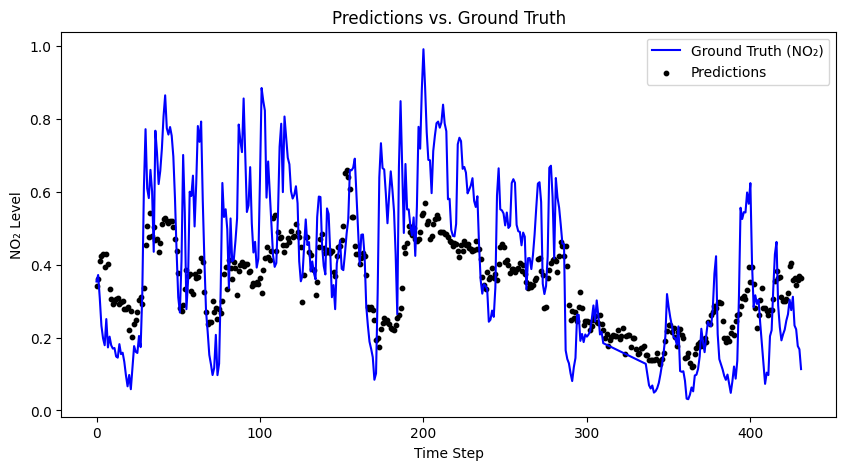

In [31]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch  # Get input and ground truth
        x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

        # Get predictions
        y_pred = best_model(x_test)

        # Store results
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to tensors
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()
plt.show()


## Simple MSE Loss function

In [23]:
best_params_baseline = {"n_hidden_layers": 4, "n_hidden_units": 194, "lr": 0.0025532081590650484, "weight_decay": 1.3029599229861795e-08, "batch_size": 16}

In [ ]:
# Train the model with the best hyperparameters
best_model_baseline = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params_baseline["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params_baseline["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__()
    loss_function="MSE",
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params_baseline["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params_baseline["batch_size"], shuffle=False)

# Train the model
best_model_baseline.train_model(train_loader, val_loader, epochs=50, lr=best_params_baseline["lr"], weight_decay=best_params_baseline["weight_decay"], device=device)

# Save the trained model
torch.save(best_model_baseline.state_dict(), f"{MODEL_PATH}/best_mlp_no2_baseline.pth")
print("Model saved as best_mlp_no2_baseline.pth in Model folder")

Epoch 1/50 - Train Loss: 0.056461 - Val Loss: 0.078200
Epoch 2/50 - Train Loss: 0.033327 - Val Loss: 0.034181
Epoch 3/50 - Train Loss: 0.024612 - Val Loss: 0.036997
Epoch 4/50 - Train Loss: 0.020388 - Val Loss: 0.027525
Epoch 5/50 - Train Loss: 0.017908 - Val Loss: 0.028525
Epoch 6/50 - Train Loss: 0.016590 - Val Loss: 0.028329
Epoch 7/50 - Train Loss: 0.018531 - Val Loss: 0.022859
Epoch 8/50 - Train Loss: 0.017043 - Val Loss: 0.021024
Epoch 9/50 - Train Loss: 0.015320 - Val Loss: 0.021388
Epoch 10/50 - Train Loss: 0.014659 - Val Loss: 0.020307
Epoch 11/50 - Train Loss: 0.015040 - Val Loss: 0.022117
Epoch 12/50 - Train Loss: 0.014961 - Val Loss: 0.022487
Epoch 13/50 - Train Loss: 0.015082 - Val Loss: 0.023689
Epoch 14/50 - Train Loss: 0.014757 - Val Loss: 0.021779
Epoch 15/50 - Train Loss: 0.015012 - Val Loss: 0.020729
Epoch 16/50 - Train Loss: 0.014366 - Val Loss: 0.020447
Epoch 17/50 - Train Loss: 0.014167 - Val Loss: 0.021481
Epoch 18/50 - Train Loss: 0.014991 - Val Loss: 0.021874
E

KeyboardInterrupt: 

In [ ]:
best_model_baseline.load_state_dict(torch.load(f"{MODEL_PATH}/best_mlp_no2_baseline.pth"))
best_model_baseline.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params_baseline["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse_baseline, rmse_val_baseline, smape_val_baseline = best_model_baseline.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")

